In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
stack = 'MD662'

# Download raw scanner files from S3

In [ ]:
! aws s3 cp --recursive --force-glacier-transfer "s3://mousebrainatlas-rawdata/CSHL_data/MD662" "/shared/CSHL_data/MD662"

# Specify raw file locations

In [11]:
# FOR MD658

# The set of dirs where we should search for image files.
raw_data_dirs = \
{(None, 'raw'): '/media/yuncong/BstemAtlasData/MD658/',
(None, 'down32'): '/media/yuncong/BstemAtlasData/MD658/'}

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{(None, 'raw'): \
 '/media/yuncong/BstemAtlasData/MD658/(.*)_lossless.jp2',
 (None, 'down32'): \
  '/media/yuncong/BstemAtlasData/MD658/(.*).png',
}

In [65]:
# FOR MD661

# The set of dirs where we should search for image files.
raw_data_dirs = \
{(None, 'raw'): '/media/yuncong/BstemAtlasData/MD661/',
(None, 'down32'): '/media/yuncong/BstemAtlasData/MD661/'}

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{(None, 'raw'): \
 '/media/yuncong/BstemAtlasData/MD661/(.*)_lossless.jp2',
 (None, 'down32'): \
  '/media/yuncong/BstemAtlasData/MD661/(.*).tif',
}

In [4]:
# FOR MD662

# The set of dirs where we should search for image files.
raw_data_dirs = \
{(None, 'raw'): '/media/yuncong/BstemAtlasData/MD662/',
(None, 'down32'): '/media/yuncong/BstemAtlasData/MD662/'}

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{(None, 'raw'): \
 '/media/yuncong/BstemAtlasData/MD662/(.*)_lossless.jp2',
 (None, 'down32'): \
  '/media/yuncong/BstemAtlasData/MD662/(.*).tif',
}

In [5]:
image_names_all_data_dirs_flattened = set([])
image_names_all_data_dirs = {}
for vr, data_dir in raw_data_dirs.iteritems():
    if data_dir is None: continue
    image_names = set([])
    if vr in input_image_filename_to_imagename_re_pattern_mapping:
        for fn in os.listdir(data_dir):
            g = re.search(input_image_filename_to_imagename_re_pattern_mapping[vr], os.path.join(data_dir, fn))
            if g is not None:
                img_name = g.groups()[0]
                image_names.add(img_name)
                image_names_all_data_dirs_flattened.add(img_name)
    image_names_all_data_dirs[vr] = image_names
    
# Make sure the every image has all three channels.
for vr, img_names in image_names_all_data_dirs.iteritems():
    print vr, 'missing:'
    print image_names_all_data_dirs_flattened - img_names
    print 

(None, 'raw') missing:
set([])

(None, 'down32') missing:
set([])



# Convert JPEG2000 to TIFF
jp2 -> raw

In [6]:
# in_dir = '/shared/CSHL_data/MD662/'
in_dir = '/media/yuncong/BstemAtlasData/MD662/'

In [7]:
# thumbnail_files = [fn for fn in os.listdir(in_dir) if 'tif' in fn]
thumbnail_files = [fn for fn in os.listdir(in_dir) if 'png' in fn]
raw_files =  [fn for fn in os.listdir(in_dir) if 'lossless' in fn]
print len(raw_files), 'raw files, ', len(thumbnail_files), 'thumbnail_files'

438 raw files,  438 thumbnail_files


In [8]:
output_dir = create_if_not_exists(DataManager.get_image_dir_v2(stack=stack, prep_id=None, resol='raw'))

In [ ]:
run_distributed('export LD_LIBRARY_PATH=%(kdu_dir)s:$LD_LIBRARY_PATH; %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(out_fp)s\"' % \
                {'kdu_bin': KDU_EXPAND_BIN, 'kdu_dir': os.path.dirname(KDU_EXPAND_BIN)},
                kwargs_list={'in_fp': [os.path.join(in_dir, img_name + '_lossless.jp2') 
                                       for img_name in list(image_names_all_data_dirs_flattened)], 
                             'out_fp': [DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version=None, fn=img_name) 
                                        for img_name in list(image_names_all_data_dirs_flattened)]},
                argument_type='single',
                jobs_per_node=1,
                local_only=True, 
                use_aws=False)

In [ ]:
# upload_to_s3(DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version=None), is_dir=True)

# Extract Neurotrace channel
raw -> raw_Ntb

In [10]:
create_if_not_exists(DataManager.get_image_dir_v2(stack=stack, prep_id=None, resol='raw', version='Ntb'))

'/data/CSHL_data_processed/MD662/MD662_raw_Ntb'

In [23]:
run_distributed('convert \"%(in_fp)s\" -channel B -separate \"%(out_fp)s\"',
                kwargs_list={'in_fp': [DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version=None, fn=img_name) 
                                       for img_name in list(image_names_all_data_dirs_flattened)], 
                             'out_fp': [DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version='Ntb', fn=img_name) 
                                        for img_name in list(image_names_all_data_dirs_flattened)]},
                argument_type='single',
                jobs_per_node=1,
                local_only=True,
               use_aws=False)

rm -f ~/stderr_*; rm -f ~/stdout_*
return code: 0
Run locally.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


# Generate thumbnail
raw_Ntb -> thumbnail_Ntb

In [104]:
thumbnail_downscale_factor = 32

In [105]:
tb_resol = 'thumbnail'

In [ ]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version='Ntb', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='Ntb', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

    # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
#     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F1-2017.06.02-17.07.55_MD661_1_0001_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 0.45 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F1-2017.06.02-17.07.55_MD661_2_0002_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 0.61 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F1-2017.06.02-17.07.55_MD661_3_0003_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 0.57 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F2-2017.06.02-

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F11-2017.06.02-20.12.07_MD661_3_0033_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 5.22 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F12-2017.06.02-20.33.07_MD661_1_0034_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 5.55 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F12-2017.06.02-20.33.07_MD661_2_0035_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 5.34 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F12-2017.06

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F21-2017.06.08-16.21.02_MD661_2_0062_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 8.34 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F21-2017.06.08-16.21.02_MD661_3_0063_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 7.70 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F22-2017.06.08-16.46.06_MD661_1_0064_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 7.15 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F22-2017.06

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 15.87 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 17.10 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 9.83 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F44-2017.

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 6.96 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 10.35 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 7.62 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F54-2017.0

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 14.24 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 12.67 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 11.95 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F63-2017

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 11.37 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 21.69 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 16.32 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F76-2017

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 10.72 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 19.04 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 21.88 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F91-2017

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 20.12 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 11.11 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 21.29 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F105-

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 9.22 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 20.78 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 15.76 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F120-2

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 11.95 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 14.70 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 14.19 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F132-

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD661_3_0420_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 13.42 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD661_1_0421_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 12.75 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD661_2_0422_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 14.05 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F141-

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F158-2017.06.08-10.33.29_MD661_3_0474_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 5.78 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F159-2017.06.08-10.58.24_MD661_1_0475_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 12.48 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F159-2017.06.08-10.58.24_MD661_2_0476_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 6.00 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F159-20

# Linear contrast stretch thumbnails
thumbnail_Ntb -> thumbnail_NtbNormalized

In [28]:
tb_resol = 'thumbnail'

In [29]:
for img_name in metadata_cache['valid_filenames'][stack]:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='Ntb', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='NtbNormalized', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
        
    cmd = """convert "%(in_fp)s" -normalize -depth 8 "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp}
    execute_command(cmd)
    
    sys.stderr.write("Intensity normalize: %.2f seconds.\n" % (time.time() - t))

convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.24 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 

return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_thumbnail_NtbNormalize

return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.13 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_thumbnail_NtbNormalize

return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_thumbnail_NtbNormalize

return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_thumbnail_NtbNormalize

return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_thumbnail_NtbNormalize

return code: 0
Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.12 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_thumbnail_NtbNormalize

Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_thumbnail_NtbNormalized.tif" 
r

return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.10 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_thumbnail_NtbNor

Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_thumbnail_NtbNormalized.tif" 
r

return code: 0
Intensity normalize: 0.08 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.09 seconds.convert "/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD661/MD661_thumbnail_NtbNormalized/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_thumbnail_NtbNor

# Transform prep1 masks back to original
prep1_thumbnail_mask -> thumbnail_mask

In [114]:
def get_original_thumbnail_from_prep1_thumbnail(img, stack, section=None, fn=None):
    
    Ts = DataManager.load_transforms_v2(stack, in_image_resolution='down32', out_image_resolution='down32',
                                   use_inverse=False)
    if fn is None:
        fn = metadata_cache['sections_to_filenames'][stack][section]
    
    img_warped = warp(img, inverse_map=Ts[fn])
    img_original = DataManager.load_image_v2(stack=stack, prep_id=None, resol='thumbnail', version='Ntb', fn=fn)
    h, w = img_original.shape
    print h, w
    return img_warped[:h, :w].astype(img.dtype)

In [122]:
for fn in valid_filenames:
    
    mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
    mask_tb_original = get_original_thumbnail_from_prep1_thumbnail(mask_tb_alignedPadded, stack=stack, fn=fn)
    
#     img_tb_original = DataManager.load_image_v2(stack=stack, prep_id=None, 
#                                          resol='thumbnail', version='NtbNormalized', 
#                                          fn=fn)
    
    mask_tb_original_fp = DataManager.get_thumbnail_mask_filename_v3(stack, prep_id=None, fn=fn)
    create_parent_dir_if_not_exists(mask_tb_original_fp)
    imsave(mask_tb_original_fp, mask_tb_original.astype(np.uint8)*255)
    upload_to_s3(mask_tb_original_fp)

#     masked_img = img_tb_raw.copy()
#     masked_img[~mask_tb_raw] = 0
    
#     plt.figure()
#     plt.imshow(masked_img, cmap=plt.cm.gray);
#     plt.show()

Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F1-2017.06.02-17.07.55_MD661_1_0001_thumbnail_Ntb.tif
428 497
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F1-2017.06.02-17.07.55_MD661_1_0001_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F1-2017.06.02-17.07.55_MD661_1_0001_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F1-2017.06.02-17.07.55_MD661_2_0002_thumbnail_Ntb.tif
450 638
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F1-2017.06.02-17.07.55_MD661_2_0002_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F1-2017.06.02-17.07.55_MD661_2_0002_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F1-2017.06.02-17.07.55_MD661_3_0003_thumbnail_Ntb.tif
512 590


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F1-2017.06.02-17.07.55_MD661_3_0003_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F1-2017.06.02-17.07.55_MD661_3_0003_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F2-2017.06.02-17.21.53_MD661_1_0004_thumbnail_Ntb.tif
673 770
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F2-2017.06.02-17.21.53_MD661_1_0004_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F2-2017.06.02-17.21.53_MD661_1_0004_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F2-2017.06.02-17.21.53_MD661_2_0005_thumbnail_Ntb.tif
673 770


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F2-2017.06.02-17.21.53_MD661_2_0005_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F2-2017.06.02-17.21.53_MD661_2_0005_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F2-2017.06.02-17.21.53_MD661_3_0006_thumbnail_Ntb.tif
673 770


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F2-2017.06.02-17.21.53_MD661_3_0006_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F2-2017.06.02-17.21.53_MD661_3_0006_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F3-2017.06.02-17.43.06_MD661_1_0007_thumbnail_Ntb.tif
674 752


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F3-2017.06.02-17.43.06_MD661_1_0007_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F3-2017.06.02-17.43.06_MD661_1_0007_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F3-2017.06.02-17.43.06_MD661_2_0008_thumbnail_Ntb.tif
674 752


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F3-2017.06.02-17.43.06_MD661_2_0008_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F3-2017.06.02-17.43.06_MD661_2_0008_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F3-2017.06.02-17.43.06_MD661_3_0009_thumbnail_Ntb.tif
674 752


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F3-2017.06.02-17.43.06_MD661_3_0009_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F3-2017.06.02-17.43.06_MD661_3_0009_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F4-2017.06.02-18.04.01_MD661_1_0010_thumbnail_Ntb.tif
673 755
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F4-2017.06.02-18.04.01_MD661_1_0010_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F4-2017.06.02-18.04.01_MD661_1_0010_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F4-2017.06.02-18.04.01_MD661_2_0011_thumbnail_Ntb.tif
673 755


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F4-2017.06.02-18.04.01_MD661_2_0011_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F4-2017.06.02-18.04.01_MD661_2_0011_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F4-2017.06.02-18.04.01_MD661_3_0012_thumbnail_Ntb.tif
673 755
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F4-2017.06.02-18.04.01_MD661_3_0012_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F4-2017.06.02-18.04.01_MD661_3_0012_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F5-2017.06.02-18.25.27_MD661_1_0013_thumbnail_Ntb.tif
674 786


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F5-2017.06.02-18.25.27_MD661_1_0013_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F5-2017.06.02-18.25.27_MD661_1_0013_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F5-2017.06.02-18.25.27_MD661_2_0014_thumbnail_Ntb.tif
674 786


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F5-2017.06.02-18.25.27_MD661_2_0014_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F5-2017.06.02-18.25.27_MD661_2_0014_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F5-2017.06.02-18.25.27_MD661_3_0015_thumbnail_Ntb.tif
674 786


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F5-2017.06.02-18.25.27_MD661_3_0015_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F5-2017.06.02-18.25.27_MD661_3_0015_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F7-2017.06.02-18.46.54_MD661_1_0019_thumbnail_Ntb.tif
671 753


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F7-2017.06.02-18.46.54_MD661_1_0019_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F7-2017.06.02-18.46.54_MD661_1_0019_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F7-2017.06.02-18.46.54_MD661_2_0020_thumbnail_Ntb.tif
671 753


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F7-2017.06.02-18.46.54_MD661_2_0020_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F7-2017.06.02-18.46.54_MD661_2_0020_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F7-2017.06.02-18.46.54_MD661_3_0021_thumbnail_Ntb.tif
671 753


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F7-2017.06.02-18.46.54_MD661_3_0021_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F7-2017.06.02-18.46.54_MD661_3_0021_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F8-2017.06.02-19.08.17_MD661_1_0022_thumbnail_Ntb.tif
675 761


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F8-2017.06.02-19.08.17_MD661_1_0022_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F8-2017.06.02-19.08.17_MD661_1_0022_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F8-2017.06.02-19.08.17_MD661_2_0023_thumbnail_Ntb.tif
675 761


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F8-2017.06.02-19.08.17_MD661_2_0023_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F8-2017.06.02-19.08.17_MD661_2_0023_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F8-2017.06.02-19.08.17_MD661_3_0024_thumbnail_Ntb.tif
675 761


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F8-2017.06.02-19.08.17_MD661_3_0024_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F8-2017.06.02-19.08.17_MD661_3_0024_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F9-2017.06.02-19.29.31_MD661_1_0025_thumbnail_Ntb.tif
672 760


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F9-2017.06.02-19.29.31_MD661_1_0025_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F9-2017.06.02-19.29.31_MD661_1_0025_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F9-2017.06.02-19.29.31_MD661_2_0026_thumbnail_Ntb.tif
672 760


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F9-2017.06.02-19.29.31_MD661_2_0026_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F9-2017.06.02-19.29.31_MD661_2_0026_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F9-2017.06.02-19.29.31_MD661_3_0027_thumbnail_Ntb.tif
672 760


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F9-2017.06.02-19.29.31_MD661_3_0027_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F9-2017.06.02-19.29.31_MD661_3_0027_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F10-2017.06.02-19.50.53_MD661_1_0028_thumbnail_Ntb.tif
672 774


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F10-2017.06.02-19.50.53_MD661_1_0028_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F10-2017.06.02-19.50.53_MD661_1_0028_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F10-2017.06.02-19.50.53_MD661_2_0029_thumbnail_Ntb.tif
672 774


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F10-2017.06.02-19.50.53_MD661_2_0029_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F10-2017.06.02-19.50.53_MD661_2_0029_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F10-2017.06.02-19.50.53_MD661_3_0030_thumbnail_Ntb.tif
672 774


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F10-2017.06.02-19.50.53_MD661_3_0030_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F10-2017.06.02-19.50.53_MD661_3_0030_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F11-2017.06.02-20.12.07_MD661_1_0031_thumbnail_Ntb.tif
672 780


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F11-2017.06.02-20.12.07_MD661_1_0031_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F11-2017.06.02-20.12.07_MD661_1_0031_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F11-2017.06.02-20.12.07_MD661_2_0032_thumbnail_Ntb.tif
672 781


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F11-2017.06.02-20.12.07_MD661_2_0032_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F11-2017.06.02-20.12.07_MD661_2_0032_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F11-2017.06.02-20.12.07_MD661_3_0033_thumbnail_Ntb.tif
672 781


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F11-2017.06.02-20.12.07_MD661_3_0033_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F11-2017.06.02-20.12.07_MD661_3_0033_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F12-2017.06.02-20.33.07_MD661_1_0034_thumbnail_Ntb.tif
678 781


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F12-2017.06.02-20.33.07_MD661_1_0034_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F12-2017.06.02-20.33.07_MD661_1_0034_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F12-2017.06.02-20.33.07_MD661_2_0035_thumbnail_Ntb.tif
678 781


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F12-2017.06.02-20.33.07_MD661_2_0035_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F12-2017.06.02-20.33.07_MD661_2_0035_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F12-2017.06.02-20.33.07_MD661_3_0036_thumbnail_Ntb.tif
678 781


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F12-2017.06.02-20.33.07_MD661_3_0036_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F12-2017.06.02-20.33.07_MD661_3_0036_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F13-2017.06.02-20.54.57_MD661_1_0037_thumbnail_Ntb.tif
675 752


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F13-2017.06.02-20.54.57_MD661_1_0037_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F13-2017.06.02-20.54.57_MD661_1_0037_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F13-2017.06.02-20.54.57_MD661_2_0038_thumbnail_Ntb.tif
675 752


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F13-2017.06.02-20.54.57_MD661_2_0038_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F13-2017.06.02-20.54.57_MD661_2_0038_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F13-2017.06.02-20.54.57_MD661_3_0039_thumbnail_Ntb.tif
675 752


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F13-2017.06.02-20.54.57_MD661_3_0039_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F13-2017.06.02-20.54.57_MD661_3_0039_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F14-2017.06.08-15.59.57_MD661_1_0040_thumbnail_Ntb.tif
768 840


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F14-2017.06.08-15.59.57_MD661_1_0040_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F14-2017.06.08-15.59.57_MD661_1_0040_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F14-2017.06.08-15.59.57_MD661_2_0041_thumbnail_Ntb.tif
720 840


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F14-2017.06.08-15.59.57_MD661_2_0041_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F14-2017.06.08-15.59.57_MD661_2_0041_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F14-2017.06.08-15.59.57_MD661_3_0042_thumbnail_Ntb.tif
720 780
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F14-2017.06.08-15.59.57_MD661_3_0042_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F14-2017.06.08-15.59.57_MD661_3_0042_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F15-2017.06.02-21.15.53_MD661_1_0043_thumbnail_Ntb.tif
674 926


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F15-2017.06.02-21.15.53_MD661_1_0043_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F15-2017.06.02-21.15.53_MD661_1_0043_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F15-2017.06.02-21.15.53_MD661_2_0044_thumbnail_Ntb.tif
674 926


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F15-2017.06.02-21.15.53_MD661_2_0044_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F15-2017.06.02-21.15.53_MD661_2_0044_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F15-2017.06.02-21.15.53_MD661_3_0045_thumbnail_Ntb.tif
674 926


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F15-2017.06.02-21.15.53_MD661_3_0045_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F15-2017.06.02-21.15.53_MD661_3_0045_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F16-2017.06.02-21.43.54_MD661_1_0046_thumbnail_Ntb.tif
678 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F16-2017.06.02-21.43.54_MD661_1_0046_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F16-2017.06.02-21.43.54_MD661_1_0046_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F16-2017.06.02-21.43.54_MD661_2_0047_thumbnail_Ntb.tif
678 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F16-2017.06.02-21.43.54_MD661_2_0047_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F16-2017.06.02-21.43.54_MD661_2_0047_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F16-2017.06.02-21.43.54_MD661_3_0048_thumbnail_Ntb.tif
678 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F16-2017.06.02-21.43.54_MD661_3_0048_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F16-2017.06.02-21.43.54_MD661_3_0048_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F17-2017.06.02-22.09.05_MD661_1_0049_thumbnail_Ntb.tif
676 881


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F17-2017.06.02-22.09.05_MD661_1_0049_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F17-2017.06.02-22.09.05_MD661_1_0049_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F17-2017.06.02-22.09.05_MD661_2_0050_thumbnail_Ntb.tif
676 881


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F17-2017.06.02-22.09.05_MD661_2_0050_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F17-2017.06.02-22.09.05_MD661_2_0050_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F17-2017.06.02-22.09.05_MD661_3_0051_thumbnail_Ntb.tif
676 881


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F17-2017.06.02-22.09.05_MD661_3_0051_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F17-2017.06.02-22.09.05_MD661_3_0051_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F18-2017.06.02-22.34.01_MD661_1_0052_thumbnail_Ntb.tif
675 877


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F18-2017.06.02-22.34.01_MD661_1_0052_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F18-2017.06.02-22.34.01_MD661_1_0052_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F18-2017.06.02-22.34.01_MD661_2_0053_thumbnail_Ntb.tif
675 877


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F18-2017.06.02-22.34.01_MD661_2_0053_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F18-2017.06.02-22.34.01_MD661_2_0053_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F18-2017.06.02-22.34.01_MD661_3_0054_thumbnail_Ntb.tif
675 877


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F18-2017.06.02-22.34.01_MD661_3_0054_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F18-2017.06.02-22.34.01_MD661_3_0054_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F19-2017.06.02-22.58.59_MD661_1_0055_thumbnail_Ntb.tif
675 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F19-2017.06.02-22.58.59_MD661_1_0055_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F19-2017.06.02-22.58.59_MD661_1_0055_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F19-2017.06.02-22.58.59_MD661_2_0056_thumbnail_Ntb.tif
675 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F19-2017.06.02-22.58.59_MD661_2_0056_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F19-2017.06.02-22.58.59_MD661_2_0056_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F19-2017.06.02-22.58.59_MD661_3_0057_thumbnail_Ntb.tif
675 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F19-2017.06.02-22.58.59_MD661_3_0057_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F19-2017.06.02-22.58.59_MD661_3_0057_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F20-2017.06.02-23.23.55_MD661_1_0058_thumbnail_Ntb.tif
678 908


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F20-2017.06.02-23.23.55_MD661_1_0058_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F20-2017.06.02-23.23.55_MD661_1_0058_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F20-2017.06.02-23.23.55_MD661_2_0059_thumbnail_Ntb.tif
678 908


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F20-2017.06.02-23.23.55_MD661_2_0059_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F20-2017.06.02-23.23.55_MD661_2_0059_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F20-2017.06.02-23.23.55_MD661_3_0060_thumbnail_Ntb.tif
678 908


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F20-2017.06.02-23.23.55_MD661_3_0060_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F20-2017.06.02-23.23.55_MD661_3_0060_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F21-2017.06.08-16.21.02_MD661_1_0061_thumbnail_Ntb.tif
760 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F21-2017.06.08-16.21.02_MD661_1_0061_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F21-2017.06.08-16.21.02_MD661_1_0061_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F21-2017.06.08-16.21.02_MD661_2_0062_thumbnail_Ntb.tif
823 1020


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F21-2017.06.08-16.21.02_MD661_2_0062_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F21-2017.06.08-16.21.02_MD661_2_0062_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F21-2017.06.08-16.21.02_MD661_3_0063_thumbnail_Ntb.tif
752 960
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F21-2017.06.08-16.21.02_MD661_3_0063_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F21-2017.06.08-16.21.02_MD661_3_0063_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F22-2017.06.08-16.46.06_MD661_1_0064_thumbnail_Ntb.tif
736 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F22-2017.06.08-16.46.06_MD661_1_0064_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F22-2017.06.08-16.46.06_MD661_1_0064_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F22-2017.06.08-16.46.06_MD661_2_0065_thumbnail_Ntb.tif
736 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F22-2017.06.08-16.46.06_MD661_2_0065_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F22-2017.06.08-16.46.06_MD661_2_0065_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F22-2017.06.08-16.46.06_MD661_3_0066_thumbnail_Ntb.tif
736 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F22-2017.06.08-16.46.06_MD661_3_0066_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F22-2017.06.08-16.46.06_MD661_3_0066_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F23-2017.06.05-11.58.13_MD661_1_0067_thumbnail_Ntb.tif
677 934


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F23-2017.06.05-11.58.13_MD661_1_0067_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F23-2017.06.05-11.58.13_MD661_1_0067_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F23-2017.06.05-11.58.13_MD661_2_0068_thumbnail_Ntb.tif
677 934


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F23-2017.06.05-11.58.13_MD661_2_0068_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F23-2017.06.05-11.58.13_MD661_2_0068_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F23-2017.06.05-11.58.13_MD661_3_0069_thumbnail_Ntb.tif
677 934


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F23-2017.06.05-11.58.13_MD661_3_0069_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F23-2017.06.05-11.58.13_MD661_3_0069_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F24-2017.06.05-12.23.11_MD661_1_0070_thumbnail_Ntb.tif
677 930


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F24-2017.06.05-12.23.11_MD661_1_0070_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F24-2017.06.05-12.23.11_MD661_1_0070_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F24-2017.06.05-12.23.11_MD661_2_0071_thumbnail_Ntb.tif
677 930
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F24-2017.06.05-12.23.11_MD661_2_0071_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F24-2017.06.05-12.23.11_MD661_2_0071_thumbnail_mask.png"

Not using image_cache.



0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F24-2017.06.05-12.23.11_MD661_3_0072_thumbnail_Ntb.tif
677 930


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F24-2017.06.05-12.23.11_MD661_3_0072_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F24-2017.06.05-12.23.11_MD661_3_0072_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F25-2017.06.05-12.48.19_MD661_1_0073_thumbnail_Ntb.tif
677 886


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F25-2017.06.05-12.48.19_MD661_1_0073_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F25-2017.06.05-12.48.19_MD661_1_0073_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F25-2017.06.05-12.48.19_MD661_2_0074_thumbnail_Ntb.tif
677 908


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F25-2017.06.05-12.48.19_MD661_2_0074_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F25-2017.06.05-12.48.19_MD661_2_0074_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F25-2017.06.05-12.48.19_MD661_3_0075_thumbnail_Ntb.tif
677 886


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F25-2017.06.05-12.48.19_MD661_3_0075_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F25-2017.06.05-12.48.19_MD661_3_0075_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F26-2017.06.05-13.12.57_MD661_1_0076_thumbnail_Ntb.tif
677 897


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F26-2017.06.05-13.12.57_MD661_1_0076_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F26-2017.06.05-13.12.57_MD661_1_0076_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F26-2017.06.05-13.12.57_MD661_2_0077_thumbnail_Ntb.tif
677 897


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F26-2017.06.05-13.12.57_MD661_2_0077_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F26-2017.06.05-13.12.57_MD661_2_0077_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F26-2017.06.05-13.12.57_MD661_3_0078_thumbnail_Ntb.tif
677 897


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F26-2017.06.05-13.12.57_MD661_3_0078_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F26-2017.06.05-13.12.57_MD661_3_0078_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F27-2017.06.05-13.37.58_MD661_1_0079_thumbnail_Ntb.tif
676 869


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F27-2017.06.05-13.37.58_MD661_1_0079_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F27-2017.06.05-13.37.58_MD661_1_0079_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F27-2017.06.05-13.37.58_MD661_2_0080_thumbnail_Ntb.tif
676 869


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F27-2017.06.05-13.37.58_MD661_2_0080_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F27-2017.06.05-13.37.58_MD661_2_0080_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F27-2017.06.05-13.37.58_MD661_3_0081_thumbnail_Ntb.tif
676 869


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F27-2017.06.05-13.37.58_MD661_3_0081_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F27-2017.06.05-13.37.58_MD661_3_0081_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F28-2017.06.05-14.02.44_MD661_1_0082_thumbnail_Ntb.tif
791 900


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F28-2017.06.05-14.02.44_MD661_1_0082_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F28-2017.06.05-14.02.44_MD661_1_0082_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F28-2017.06.05-14.02.44_MD661_2_0083_thumbnail_Ntb.tif
724 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F28-2017.06.05-14.02.44_MD661_2_0083_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F28-2017.06.05-14.02.44_MD661_2_0083_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F28-2017.06.05-14.02.44_MD661_3_0084_thumbnail_Ntb.tif
673 714


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F28-2017.06.05-14.02.44_MD661_3_0084_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F28-2017.06.05-14.02.44_MD661_3_0084_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F29-2017.06.05-14.26.10_MD661_1_0085_thumbnail_Ntb.tif
676 873


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F29-2017.06.05-14.26.10_MD661_1_0085_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F29-2017.06.05-14.26.10_MD661_1_0085_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F29-2017.06.05-14.26.10_MD661_2_0086_thumbnail_Ntb.tif
676 873


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F29-2017.06.05-14.26.10_MD661_2_0086_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F29-2017.06.05-14.26.10_MD661_2_0086_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F29-2017.06.05-14.26.10_MD661_3_0087_thumbnail_Ntb.tif
676 873


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F29-2017.06.05-14.26.10_MD661_3_0087_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F29-2017.06.05-14.26.10_MD661_3_0087_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_thumbnail_Ntb.tif
673 828


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_thumbnail_Ntb.tif
673 828


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_thumbnail_Ntb.tif
673 816


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_thumbnail_Ntb.tif
705 979


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_thumbnail_Ntb.tif
674 1010


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_thumbnail_Ntb.tif
674 1054


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_thumbnail_Ntb.tif
859 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_thumbnail_Ntb.tif
768 1200


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_thumbnail_Ntb.tif
841 1080


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_thumbnail_Ntb.tif
732 928


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_thumbnail_Ntb.tif
741 1047


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_thumbnail_Ntb.tif
746 1003


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_thumbnail_Ntb.tif
775 957


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_thumbnail_Ntb.tif
735 992


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_thumbnail_Ntb.tif
753 983


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_thumbnail_Ntb.tif
884 904


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_thumbnail_Ntb.tif
795 1014


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_thumbnail_Ntb.tif
698 1023
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_thumbnail_Ntb.tif
920 840


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_thumbnail_Ntb.tif
809 950


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_thumbnail_Ntb.tif
840 1065


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_thumbnail_Ntb.tif
796 988


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_thumbnail_Ntb.tif
734 1001
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_thumbnail_mask.png"

Not using image_cache.



0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_thumbnail_Ntb.tif
730 1010


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_thumbnail_Ntb.tif
807 941


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_thumbnail_Ntb.tif
807 950


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_thumbnail_Ntb.tif
762 884


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_thumbnail_Ntb.tif
819 873


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_thumbnail_Ntb.tif
686 1036


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_thumbnail_Ntb.tif
744 1041


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_thumbnail_Ntb.tif
812 1080


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_thumbnail_Ntb.tif
812 1320


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_thumbnail_Ntb.tif
739 966


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_thumbnail_Ntb.tif
751 904


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_thumbnail_Ntb.tif
747 963


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_thumbnail_Ntb.tif
711 915


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_thumbnail_Ntb.tif
858 997


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_thumbnail_Ntb.tif
805 1036
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_thumbnail_Ntb.tif
686 864


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_thumbnail_Ntb.tif
779 1054


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_thumbnail_Ntb.tif
762 1085


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_thumbnail_Ntb.tif
757 1111


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_thumbnail_Ntb.tif
872 1080


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_thumbnail_Ntb.tif
859 1200


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_thumbnail_Ntb.tif
768 1080


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_thumbnail_Ntb.tif
791 988


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_thumbnail_Ntb.tif
760 1005


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_thumbnail_Ntb.tif
782 1050


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_thumbnail_Ntb.tif
793 934


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_thumbnail_Ntb.tif
806 1016


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_thumbnail_Ntb.tif
806 1030


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_thumbnail_Ntb.tif
808 1019


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_thumbnail_Ntb.tif
759 1085


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_thumbnail_Ntb.tif
790 1107


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_thumbnail_Ntb.tif
796 1020


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_thumbnail_Ntb.tif
796 1140


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_thumbnail_Ntb.tif
796 1080


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_thumbnail_Ntb.tif
777 939


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_thumbnail_Ntb.tif
782 994


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_thumbnail_Ntb.tif
795 1052


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_thumbnail_Ntb.tif
773 997


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_thumbnail_Ntb.tif
720 1028


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_thumbnail_Ntb.tif
746 1045


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_thumbnail_Ntb.tif
796 1080


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_thumbnail_Ntb.tif
796 1200


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_thumbnail_Ntb.tif
716 999


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_thumbnail_Ntb.tif
778 1028


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_thumbnail_Ntb.tif
747 1015


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_thumbnail_Ntb.tif
747 972
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_thumbnail_Ntb.tif
634 1043


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_thumbnail_Ntb.tif
697 1074


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_thumbnail_Ntb.tif
697 1056
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_thumbnail_Ntb.tif
688 1052


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_thumbnail_Ntb.tif
720 1063


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_thumbnail_Ntb.tif
724 1063


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_thumbnail_Ntb.tif
723 969


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_thumbnail_Ntb.tif
750 994


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_thumbnail_Ntb.tif
750 1027


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_thumbnail_Ntb.tif
681 968


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_thumbnail_Ntb.tif
744 1046


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_thumbnail_Ntb.tif
740 971


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_thumbnail_Ntb.tif
684 986


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_thumbnail_Ntb.tif
698 1048


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_thumbnail_Ntb.tif
702 935


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_thumbnail_Ntb.tif
745 1022


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_thumbnail_Ntb.tif
746 1038


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_thumbnail_Ntb.tif
754 916


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_thumbnail_Ntb.tif
699 961


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_thumbnail_Ntb.tif
739 1120


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_thumbnail_Ntb.tif
757 1120


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_thumbnail_Ntb.tif
784 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_thumbnail_Ntb.tif
762 1074


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_thumbnail_Ntb.tif
745 995


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_thumbnail_Ntb.tif
757 939


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_thumbnail_Ntb.tif
735 1056


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_thumbnail_Ntb.tif
722 981


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_thumbnail_Ntb.tif
673 876


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_thumbnail_Ntb.tif
673 1087


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_thumbnail_Ntb.tif
673 1075


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_thumbnail_Ntb.tif
638 940


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_thumbnail_Ntb.tif
647 1055


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_thumbnail_Ntb.tif
638 995


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_thumbnail_Ntb.tif
628 1045


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_thumbnail_Ntb.tif
664 1051


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_thumbnail_Ntb.tif
628 1053


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_thumbnail_Ntb.tif
730 1001


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_thumbnail_Ntb.tif
717 1082


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_thumbnail_Ntb.tif
721 1008


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_thumbnail_Ntb.tif
660 1063


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_thumbnail_Ntb.tif
687 1249


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_thumbnail_Ntb.tif
692 960


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_thumbnail_Ntb.tif
652 1028


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_thumbnail_Ntb.tif
706 1157


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_thumbnail_Ntb.tif
679 991


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_thumbnail_Ntb.tif
711 1032


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_thumbnail_Ntb.tif
684 1165


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_thumbnail_Ntb.tif
716 1013


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_thumbnail_Ntb.tif
759 1292


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_thumbnail_Ntb.tif
719 1385


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_thumbnail_Ntb.tif
754 1344


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_thumbnail_Ntb.tif
714 1229


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_thumbnail_Ntb.tif
729 1353


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_thumbnail_Ntb.tif
693 1366


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_thumbnail_Ntb.tif
782 1420


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_thumbnail_Ntb.tif
729 1460


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_thumbnail_Ntb.tif
696 1435


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_thumbnail_Ntb.tif
749 1377


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_thumbnail_Ntb.tif
796 1379


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_thumbnail_Ntb.tif
747 1410


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_thumbnail_Ntb.tif
729 1379


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_thumbnail_Ntb.tif
737 1388


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_thumbnail_Ntb.tif
733 1332


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_thumbnail_Ntb.tif
764 1372


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_thumbnail_Ntb.tif
745 1459


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_thumbnail_Ntb.tif
718 1450


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_thumbnail_Ntb.tif
751 1384


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_thumbnail_Ntb.tif
751 1428


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_thumbnail_Ntb.tif
769 1372


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_thumbnail_Ntb.tif
800 1372


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_thumbnail_Ntb.tif
757 1339


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_thumbnail_Ntb.tif
726 1401


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_thumbnail_Ntb.tif
763 1443


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_thumbnail_Ntb.tif
768 1399


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_thumbnail_Ntb.tif
712 1432


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_thumbnail_Ntb.tif
725 1414


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_thumbnail_Ntb.tif
758 1417


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_thumbnail_Ntb.tif
740 1395


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_thumbnail_Ntb.tif
753 1379


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_thumbnail_Ntb.tif
753 1410


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_thumbnail_Ntb.tif
717 1412


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_thumbnail_Ntb.tif
712 1443


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_thumbnail_Ntb.tif
694 1420


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_thumbnail_Ntb.tif
747 1459


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_thumbnail_Ntb.tif
731 1461


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_thumbnail_Ntb.tif
700 1382


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_thumbnail_Ntb.tif
708 1432


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_thumbnail_Ntb.tif
770 1401


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_thumbnail_Ntb.tif
706 1408


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_thumbnail_Ntb.tif
772 1412


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_thumbnail_Ntb.tif
694 1260


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_thumbnail_Ntb.tif
787 1344


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_thumbnail_Ntb.tif
756 1414


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_thumbnail_Ntb.tif
747 1361


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_thumbnail_Ntb.tif
758 1392


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_thumbnail_Ntb.tif
789 1322


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_thumbnail_Ntb.tif
787 1401


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_thumbnail_Ntb.tif
765 1375


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_thumbnail_Ntb.tif
730 1459


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_thumbnail_Ntb.tif
761 1419


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_thumbnail_Ntb.tif
811 1349


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_thumbnail_Ntb.tif
762 1278


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_thumbnail_Ntb.tif
789 1450


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_thumbnail_Ntb.tif
709 1472


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_thumbnail_Ntb.tif
734 1435


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_thumbnail_Ntb.tif
747 1421


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_thumbnail_Ntb.tif
721 1245


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_thumbnail_Ntb.tif
765 1333


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_thumbnail_Ntb.tif
746 1385


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_thumbnail_Ntb.tif
719 1323


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_thumbnail_Ntb.tif
694 1372


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_thumbnail_Ntb.tif
698 1368


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_thumbnail_Ntb.tif
751 1376


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_thumbnail_Ntb.tif
733 1381


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_thumbnail_Ntb.tif
716 1414


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_thumbnail_Ntb.tif
756 1392


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_thumbnail_Ntb.tif
746 1443


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_thumbnail_Ntb.tif
763 1488


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_thumbnail_Ntb.tif
764 1383


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_thumbnail_Ntb.tif
756 1423


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_thumbnail_Ntb.tif
755 1383


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_thumbnail_Ntb.tif
760 1219


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_thumbnail_Ntb.tif
774 1397


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_thumbnail_Ntb.tif
721 1419


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_thumbnail_Ntb.tif
732 1293


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_thumbnail_Ntb.tif
772 1382


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_thumbnail_Ntb.tif
706 1304


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_thumbnail_Ntb.tif
720 1370


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_thumbnail_Ntb.tif
740 1361


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_thumbnail_Ntb.tif
727 1313


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_thumbnail_Ntb.tif
742 1355


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_thumbnail_Ntb.tif
720 1355


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_thumbnail_Ntb.tif
756 1397


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_thumbnail_Ntb.tif
720 1366


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_thumbnail_Ntb.tif
749 1348


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_thumbnail_Ntb.tif
731 1392


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_thumbnail_Ntb.tif
716 1357


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_thumbnail_Ntb.tif
747 1335


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_thumbnail_Ntb.tif
757 1339


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_thumbnail_Ntb.tif
740 1489


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_thumbnail_Ntb.tif
838 1523


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_thumbnail_Ntb.tif
758 1412


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_thumbnail_Ntb.tif
713 1183


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_thumbnail_Ntb.tif
722 1187


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_thumbnail_Ntb.tif
653 1310


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_thumbnail_Ntb.tif
661 1345


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_thumbnail_Ntb.tif

Not using image_cache.



842 1231
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_thumbnail_Ntb.tif
740 1187


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_thumbnail_Ntb.tif
748 1149


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_thumbnail_Ntb.tif
735 1118


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_thumbnail_Ntb.tif
730 1167


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_thumbnail_Ntb.tif
784 1273


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_thumbnail_Ntb.tif
759 1171
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_thumbnail_Ntb.tif
781 1180


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_thumbnail_Ntb.tif
760 1205


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_thumbnail_Ntb.tif
786 1130


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_thumbnail_Ntb.tif
826 1166


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_thumbnail_Ntb.tif
778 1113


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_thumbnail_Ntb.tif
766 1140


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_thumbnail_Ntb.tif
771 1193


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_thumbnail_Ntb.tif
777 1117


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_thumbnail_Ntb.tif
741 1157


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_thumbnail_Ntb.tif
770 1019


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_thumbnail_Ntb.tif
788 1076


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_thumbnail_Ntb.tif
765 1063


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_thumbnail_Ntb.tif
793 1072


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_thumbnail_Ntb.tif
766 1010
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_thumbnail_Ntb.tif
806 1041


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_thumbnail_Ntb.tif
762 956


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_thumbnail_Ntb.tif
801 982


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_thumbnail_Ntb.tif
757 917


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_thumbnail_Ntb.tif
767 979


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_thumbnail_Ntb.tif
776 966


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_thumbnail_Ntb.tif
780 1050


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_thumbnail_Ntb.tif
732 992


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_thumbnail_Ntb.tif
758 1001


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_thumbnail_Ntb.tif
749 992


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_thumbnail_Ntb.tif
728 990


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_thumbnail_Ntb.tif
763 1007


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_thumbnail_Ntb.tif
732 967


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_thumbnail_Ntb.tif
772 941


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_thumbnail_Ntb.tif
749 946


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_thumbnail_Ntb.tif
767 946


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_thumbnail_Ntb.tif
718 952


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_thumbnail_Ntb.tif
735 908


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_thumbnail_Ntb.tif
704 930


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_thumbnail_Ntb.tif
743 970


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_thumbnail_mask.png"
0


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_thumbnail_Ntb.tif
765 939
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_thumbnail_Ntb.tif
747 948


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_thumbnail_Ntb.tif
642 966


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_thumbnail_Ntb.tif
677 1081


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_thumbnail_Ntb.tif
646 970


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_thumbnail_Ntb.tif
726 1003


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_thumbnail_Ntb.tif
726 972


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_thumbnail_Ntb.tif
691 998


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_thumbnail_Ntb.tif
748 883


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_thumbnail_Ntb.tif
792 940


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_thumbnail_Ntb.tif
752 896


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_thumbnail_Ntb.tif
706 952


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_thumbnail_Ntb.tif
733 956


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_thumbnail_Ntb.tif
724 961


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_thumbnail_Ntb.tif
709 994


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_thumbnail_Ntb.tif
727 1003


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD661_3_0420_thumbnail_Ntb.tif
691 990


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD661_3_0420_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD661_3_0420_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD661_1_0421_thumbnail_Ntb.tif
713 946
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD661_1_0421_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD661_1_0421_thumbnail_mask.png"

Not using image_cache.



0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD661_2_0422_thumbnail_Ntb.tif
726 981


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD661_2_0422_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD661_2_0422_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD661_3_0423_thumbnail_Ntb.tif
713 990


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD661_3_0423_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD661_3_0423_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD661_1_0424_thumbnail_Ntb.tif
776 900


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD661_1_0424_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD661_1_0424_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD661_2_0425_thumbnail_Ntb.tif
772 1020


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD661_2_0425_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD661_2_0425_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD661_3_0426_thumbnail_Ntb.tif
772 1020


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD661_3_0426_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD661_3_0426_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD661_1_0427_thumbnail_Ntb.tif
671 899
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD661_1_0427_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD661_1_0427_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD661_2_0428_thumbnail_Ntb.tif
671 899


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD661_2_0428_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD661_2_0428_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD661_3_0429_thumbnail_Ntb.tif
671 899


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD661_3_0429_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD661_3_0429_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD661_1_0430_thumbnail_Ntb.tif
677 903


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD661_1_0430_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD661_1_0430_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD661_2_0431_thumbnail_Ntb.tif
677 903


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD661_2_0431_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD661_2_0431_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD661_3_0432_thumbnail_Ntb.tif
677 903


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD661_3_0432_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD661_3_0432_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD661_1_0433_thumbnail_Ntb.tif
671 889
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD661_1_0433_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD661_1_0433_thumbnail_mask.png"

Not using image_cache.



0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD661_2_0434_thumbnail_Ntb.tif
671 889


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD661_2_0434_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD661_2_0434_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD661_3_0435_thumbnail_Ntb.tif
671 889


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD661_3_0435_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD661_3_0435_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F146-2017.06.08-02.07.21_MD661_1_0436_thumbnail_Ntb.tif
675 929


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F146-2017.06.08-02.07.21_MD661_1_0436_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F146-2017.06.08-02.07.21_MD661_1_0436_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F146-2017.06.08-02.07.21_MD661_2_0437_thumbnail_Ntb.tif
675 929


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F146-2017.06.08-02.07.21_MD661_2_0437_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F146-2017.06.08-02.07.21_MD661_2_0437_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F146-2017.06.08-02.07.21_MD661_3_0438_thumbnail_Ntb.tif
675 929


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F146-2017.06.08-02.07.21_MD661_3_0438_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F146-2017.06.08-02.07.21_MD661_3_0438_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F147-2017.06.08-02.33.03_MD661_1_0439_thumbnail_Ntb.tif
675 921


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F147-2017.06.08-02.33.03_MD661_1_0439_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F147-2017.06.08-02.33.03_MD661_1_0439_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F147-2017.06.08-02.33.03_MD661_2_0440_thumbnail_Ntb.tif
675 921


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F147-2017.06.08-02.33.03_MD661_2_0440_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F147-2017.06.08-02.33.03_MD661_2_0440_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F147-2017.06.08-02.33.03_MD661_3_0441_thumbnail_Ntb.tif
675 921


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F147-2017.06.08-02.33.03_MD661_3_0441_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F147-2017.06.08-02.33.03_MD661_3_0441_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F148-2017.06.08-02.58.49_MD661_1_0442_thumbnail_Ntb.tif
676 906


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F148-2017.06.08-02.58.49_MD661_1_0442_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F148-2017.06.08-02.58.49_MD661_1_0442_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F148-2017.06.08-02.58.49_MD661_2_0443_thumbnail_Ntb.tif
676 906


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F148-2017.06.08-02.58.49_MD661_2_0443_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F148-2017.06.08-02.58.49_MD661_2_0443_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F148-2017.06.08-02.58.49_MD661_3_0444_thumbnail_Ntb.tif
676 906


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F148-2017.06.08-02.58.49_MD661_3_0444_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F148-2017.06.08-02.58.49_MD661_3_0444_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F149-2017.06.08-03.23.49_MD661_1_0445_thumbnail_Ntb.tif
678 898
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F149-2017.06.08-03.23.49_MD661_1_0445_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F149-2017.06.08-03.23.49_MD661_1_0445_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F149-2017.06.08-03.23.49_MD661_2_0446_thumbnail_Ntb.tif
678 898


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F149-2017.06.08-03.23.49_MD661_2_0446_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F149-2017.06.08-03.23.49_MD661_2_0446_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F149-2017.06.08-03.23.49_MD661_3_0447_thumbnail_Ntb.tif
678 898


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F149-2017.06.08-03.23.49_MD661_3_0447_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F149-2017.06.08-03.23.49_MD661_3_0447_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F150-2017.06.07-05.49.02_MD661_1_0448_thumbnail_Ntb.tif
631 864


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F150-2017.06.07-05.49.02_MD661_1_0448_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F150-2017.06.07-05.49.02_MD661_1_0448_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F150-2017.06.07-05.49.02_MD661_2_0449_thumbnail_Ntb.tif
578 767


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F150-2017.06.07-05.49.02_MD661_2_0449_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F150-2017.06.07-05.49.02_MD661_2_0449_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F150-2017.06.07-05.49.02_MD661_3_0450_thumbnail_Ntb.tif
578 776


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F150-2017.06.07-05.49.02_MD661_3_0450_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F150-2017.06.07-05.49.02_MD661_3_0450_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F151-2017.06.08-03.49.47_MD661_1_0451_thumbnail_Ntb.tif
670 885


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F151-2017.06.08-03.49.47_MD661_1_0451_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F151-2017.06.08-03.49.47_MD661_1_0451_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F151-2017.06.08-03.49.47_MD661_2_0452_thumbnail_Ntb.tif
670 885


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F151-2017.06.08-03.49.47_MD661_2_0452_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F151-2017.06.08-03.49.47_MD661_2_0452_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F151-2017.06.08-03.49.47_MD661_3_0453_thumbnail_Ntb.tif
670 885


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F151-2017.06.08-03.49.47_MD661_3_0453_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F151-2017.06.08-03.49.47_MD661_3_0453_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F152-2017.06.08-04.14.54_MD661_1_0454_thumbnail_Ntb.tif
627 781


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F152-2017.06.08-04.14.54_MD661_1_0454_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F152-2017.06.08-04.14.54_MD661_1_0454_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F152-2017.06.08-04.14.54_MD661_2_0455_thumbnail_Ntb.tif
583 772


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F152-2017.06.08-04.14.54_MD661_2_0455_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F152-2017.06.08-04.14.54_MD661_2_0455_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F152-2017.06.08-04.14.54_MD661_3_0456_thumbnail_Ntb.tif
596 772


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F152-2017.06.08-04.14.54_MD661_3_0456_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F152-2017.06.08-04.14.54_MD661_3_0456_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F153-2017.06.08-04.36.42_MD661_1_0457_thumbnail_Ntb.tif
519 862


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F153-2017.06.08-04.36.42_MD661_1_0457_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F153-2017.06.08-04.36.42_MD661_1_0457_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F153-2017.06.08-04.36.42_MD661_2_0458_thumbnail_Ntb.tif
581 800


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F153-2017.06.08-04.36.42_MD661_2_0458_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F153-2017.06.08-04.36.42_MD661_2_0458_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F153-2017.06.08-04.36.42_MD661_3_0459_thumbnail_Ntb.tif
444 809


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F153-2017.06.08-04.36.42_MD661_3_0459_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F153-2017.06.08-04.36.42_MD661_3_0459_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F154-2017.06.08-04.58.31_MD661_1_0460_thumbnail_Ntb.tif
603 820


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F154-2017.06.08-04.58.31_MD661_1_0460_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F154-2017.06.08-04.58.31_MD661_1_0460_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F154-2017.06.08-04.58.31_MD661_2_0461_thumbnail_Ntb.tif
612 807


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F154-2017.06.08-04.58.31_MD661_2_0461_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F154-2017.06.08-04.58.31_MD661_2_0461_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F154-2017.06.08-04.58.31_MD661_3_0462_thumbnail_Ntb.tif
532 763


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F154-2017.06.08-04.58.31_MD661_3_0462_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F154-2017.06.08-04.58.31_MD661_3_0462_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F155-2017.06.08-05.19.51_MD661_1_0463_thumbnail_Ntb.tif
502 723


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F155-2017.06.08-05.19.51_MD661_1_0463_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F155-2017.06.08-05.19.51_MD661_1_0463_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F155-2017.06.08-05.19.51_MD661_2_0464_thumbnail_Ntb.tif
564 772


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F155-2017.06.08-05.19.51_MD661_2_0464_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F155-2017.06.08-05.19.51_MD661_2_0464_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F155-2017.06.08-05.19.51_MD661_3_0465_thumbnail_Ntb.tif
520 732


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F155-2017.06.08-05.19.51_MD661_3_0465_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F155-2017.06.08-05.19.51_MD661_3_0465_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F156-2017.06.08-05.40.36_MD661_1_0466_thumbnail_Ntb.tif
573 813
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F156-2017.06.08-05.40.36_MD661_1_0466_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F156-2017.06.08-05.40.36_MD661_1_0466_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F156-2017.06.08-05.40.36_MD661_2_0467_thumbnail_Ntb.tif
555 791
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F156-2017.06.08-05.40.36_MD661_2_0467_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F156-2017.06.08-05.40.36_MD661_2_0467_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F156-2017.06.08-05.40.36_MD661_3_0468_thumbnail_Ntb.tif
516 716


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F156-2017.06.08-05.40.36_MD661_3_0468_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F156-2017.06.08-05.40.36_MD661_3_0468_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F157-2017.06.08-06.01.11_MD661_1_0469_thumbnail_Ntb.tif
580 789


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F157-2017.06.08-06.01.11_MD661_1_0469_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F157-2017.06.08-06.01.11_MD661_1_0469_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F157-2017.06.08-06.01.11_MD661_2_0470_thumbnail_Ntb.tif
545 697


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F157-2017.06.08-06.01.11_MD661_2_0470_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F157-2017.06.08-06.01.11_MD661_2_0470_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F157-2017.06.08-06.01.11_MD661_3_0471_thumbnail_Ntb.tif
554 688


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F157-2017.06.08-06.01.11_MD661_3_0471_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F157-2017.06.08-06.01.11_MD661_3_0471_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F158-2017.06.08-10.33.29_MD661_1_0472_thumbnail_Ntb.tif
670 882


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F158-2017.06.08-10.33.29_MD661_1_0472_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F158-2017.06.08-10.33.29_MD661_1_0472_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F158-2017.06.08-10.33.29_MD661_2_0473_thumbnail_Ntb.tif
670 882


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F158-2017.06.08-10.33.29_MD661_2_0473_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F158-2017.06.08-10.33.29_MD661_2_0473_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F158-2017.06.08-10.33.29_MD661_3_0474_thumbnail_Ntb.tif
670 882


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F158-2017.06.08-10.33.29_MD661_3_0474_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F158-2017.06.08-10.33.29_MD661_3_0474_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F159-2017.06.08-10.58.24_MD661_1_0475_thumbnail_Ntb.tif
673 900


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F159-2017.06.08-10.58.24_MD661_1_0475_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F159-2017.06.08-10.58.24_MD661_1_0475_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F159-2017.06.08-10.58.24_MD661_2_0476_thumbnail_Ntb.tif
673 900


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F159-2017.06.08-10.58.24_MD661_2_0476_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F159-2017.06.08-10.58.24_MD661_2_0476_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F159-2017.06.08-10.58.24_MD661_3_0477_thumbnail_Ntb.tif
673 900


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F159-2017.06.08-10.58.24_MD661_3_0477_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F159-2017.06.08-10.58.24_MD661_3_0477_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F160-2017.06.08-06.22.55_MD661_1_0478_thumbnail_Ntb.tif
509 583


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F160-2017.06.08-06.22.55_MD661_1_0478_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F160-2017.06.08-06.22.55_MD661_1_0478_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F160-2017.06.08-06.22.55_MD661_2_0479_thumbnail_Ntb.tif
469 561
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F160-2017.06.08-06.22.55_MD661_2_0479_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F160-2017.06.08-06.22.55_MD661_2_0479_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F160-2017.06.08-06.22.55_MD661_3_0480_thumbnail_Ntb.tif
460 570


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F160-2017.06.08-06.22.55_MD661_3_0480_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F160-2017.06.08-06.22.55_MD661_3_0480_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F161-2017.06.08-11.23.08_MD661_1_0481_thumbnail_Ntb.tif
677 750


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F161-2017.06.08-11.23.08_MD661_1_0481_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F161-2017.06.08-11.23.08_MD661_1_0481_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F161-2017.06.08-11.23.08_MD661_2_0482_thumbnail_Ntb.tif
677 750


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F161-2017.06.08-11.23.08_MD661_2_0482_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F161-2017.06.08-11.23.08_MD661_2_0482_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F161-2017.06.08-11.23.08_MD661_3_0483_thumbnail_Ntb.tif
677 750


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F161-2017.06.08-11.23.08_MD661_3_0483_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F161-2017.06.08-11.23.08_MD661_3_0483_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F162-2017.06.08-06.40.13_MD661_1_0484_thumbnail_Ntb.tif
448 563
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F162-2017.06.08-06.40.13_MD661_1_0484_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F162-2017.06.08-06.40.13_MD661_1_0484_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F162-2017.06.08-06.40.13_MD661_2_0485_thumbnail_Ntb.tif
457 563


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F162-2017.06.08-06.40.13_MD661_2_0485_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F162-2017.06.08-06.40.13_MD661_2_0485_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F162-2017.06.08-06.40.13_MD661_3_0486_thumbnail_Ntb.tif
448 563


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F162-2017.06.08-06.40.13_MD661_3_0486_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F162-2017.06.08-06.40.13_MD661_3_0486_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F163-2017.06.08-11.45.10_MD661_1_0487_thumbnail_Ntb.tif
671 750


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F163-2017.06.08-11.45.10_MD661_1_0487_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F163-2017.06.08-11.45.10_MD661_1_0487_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F163-2017.06.08-11.45.10_MD661_2_0488_thumbnail_Ntb.tif
671 750


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F163-2017.06.08-11.45.10_MD661_2_0488_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F163-2017.06.08-11.45.10_MD661_2_0488_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F163-2017.06.08-11.45.10_MD661_3_0489_thumbnail_Ntb.tif
671 750


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F163-2017.06.08-11.45.10_MD661_3_0489_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F163-2017.06.08-11.45.10_MD661_3_0489_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F164-2017.06.08-06.56.25_MD661_1_0490_thumbnail_Ntb.tif
428 550


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F164-2017.06.08-06.56.25_MD661_1_0490_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F164-2017.06.08-06.56.25_MD661_1_0490_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F164-2017.06.08-06.56.25_MD661_2_0491_thumbnail_Ntb.tif
419 488


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F164-2017.06.08-06.56.25_MD661_2_0491_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F164-2017.06.08-06.56.25_MD661_2_0491_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F164-2017.06.08-06.56.25_MD661_3_0492_thumbnail_Ntb.tif
428 488


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F164-2017.06.08-06.56.25_MD661_3_0492_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F164-2017.06.08-06.56.25_MD661_3_0492_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F165-2017.06.08-07.11.35_MD661_1_0493_thumbnail_Ntb.tif
412 466


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F165-2017.06.08-07.11.35_MD661_1_0493_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F165-2017.06.08-07.11.35_MD661_1_0493_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F165-2017.06.08-07.11.35_MD661_2_0494_thumbnail_Ntb.tif
404 457


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F165-2017.06.08-07.11.35_MD661_2_0494_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F165-2017.06.08-07.11.35_MD661_2_0494_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F165-2017.06.08-07.11.35_MD661_3_0495_thumbnail_Ntb.tif
404 457
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F165-2017.06.08-07.11.35_MD661_3_0495_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F165-2017.06.08-07.11.35_MD661_3_0495_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F166-2017.06.08-12.07.10_MD661_1_0496_thumbnail_Ntb.tif
499 587
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F166-2017.06.08-12.07.10_MD661_1_0496_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F166-2017.06.08-12.07.10_MD661_1_0496_thumbnail_mask.png"


Not using image_cache.


0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F166-2017.06.08-12.07.10_MD661_2_0497_thumbnail_Ntb.tif
500 587


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F166-2017.06.08-12.07.10_MD661_2_0497_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F166-2017.06.08-12.07.10_MD661_2_0497_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F166-2017.06.08-12.07.10_MD661_3_0498_thumbnail_Ntb.tif
499 587


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F166-2017.06.08-12.07.10_MD661_3_0498_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F166-2017.06.08-12.07.10_MD661_3_0498_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F167-2017.06.08-07.26.12_MD661_1_0499_thumbnail_Ntb.tif
357 457


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F167-2017.06.08-07.26.12_MD661_1_0499_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F167-2017.06.08-07.26.12_MD661_1_0499_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F167-2017.06.08-07.26.12_MD661_2_0500_thumbnail_Ntb.tif
348 395


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F167-2017.06.08-07.26.12_MD661_2_0500_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F167-2017.06.08-07.26.12_MD661_2_0500_thumbnail_mask.png"
0
/data/CSHL_data_processed/MD661/MD661_thumbnail_Ntb/MD662&661-F167-2017.06.08-07.26.12_MD661_3_0501_thumbnail_Ntb.tif
366 412


Not using image_cache.


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F167-2017.06.08-07.26.12_MD661_3_0501_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_thumbnail_mask/MD662&661-F167-2017.06.08-07.26.12_MD661_3_0501_thumbnail_mask.png"
0


In [23]:
# t = time.time()
# sys.stderr.write('expanding...')

# in_fps = [fn + '_lossless.jp2' for fn in metadata_cache['valid_filenames'][stack]]
# out_fps = [DataManager.get_image_filepath_v2(stack=stack, prep_id=1, resol='lossless', fn=fn) 
#            for fn in metadata_cache['valid_filenames'][stack]]

# run_distributed('export LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH; %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(out_fp)s\"' % \
#                 {'kdu_bin': KDU_EXPAND_BIN},
#                 kwargs_list={'in_fp': in_fps, 'out_fp': out_fps},
#                 argument_type='single',
#                cluster_size=16)

# wait_qsub_complete()

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

# Convert alignedBrainstemCrop bbox from txt to json

In [31]:
# alignedBrainstemCrop_xmin, alignedBrainstemCrop_xmax, \
# alignedBrainstemCrop_ymin, alignedBrainstemCrop_ymax = DataManager.load_cropbox_v2(stack=stack, only_2d=True)

In [32]:
# alignedBrainstemCrop_cropbox = {'rostral_limit': alignedBrainstemCrop_xmin, 'caudal_limit': alignedBrainstemCrop_xmax, 
#  'dorsal_limit': alignedBrainstemCrop_ymin, 'ventral_limit': alignedBrainstemCrop_ymax}

In [33]:
# save_data(alignedBrainstemCrop_cropbox, 
#           DataManager.get_cropbox_filename_v2(stack=stack, anchor_fn=None, prep_id='alignedBrainstemCrop'))

# Brightness correction
raw_Ntb -> raw_NtbNormalizedAdaptiveInvertedGamma 

# Identify bounding box for "wholebrainWithMargin" based on prep1 mask

In [87]:
tb_resol = 'down32'

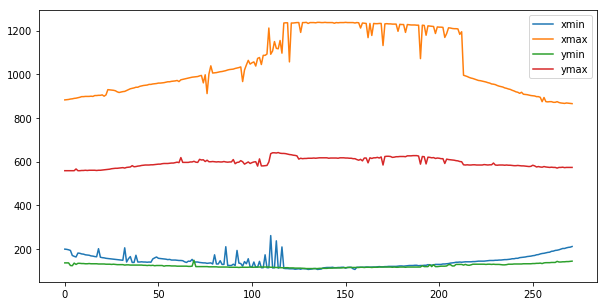

57 1288 61 692
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_alignedTo_MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep5_cropbox.json" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_alignedTo_MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep5_cropbox.json"
0


In [91]:
for stack in ['MD661']:
    
    bbox_all_images = []
    for fn in metadata_cache['valid_filenames'][stack]:
        mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
        bbox = bbox_2d(mask_tb_alignedPadded)
        bbox_all_images.append(bbox)
    bbox_all_images = np.array(bbox_all_images)

#     bbox_all_images = np.array([
#         bbox_2d(DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn))
#         for fn in metadata_cache['valid_filenames'][stack]
#     ])
    
    # Are the bounding boxes reasonable? If some numbers stand out, go back to check the mask.
    plt.figure(figsize=(10,5));
    plt.plot(bbox_all_images[:,0], label='xmin')
    plt.plot(bbox_all_images[:,1], label='xmax')
    plt.plot(bbox_all_images[:,2], label='ymin')
    plt.plot(bbox_all_images[:,3], label='ymax')
    plt.legend();
    plt.show();
    
    margin_um = 736
    margin = int(np.round(margin_um / convert_resolution_string_to_um(resolution=tb_resol, stack=stack)))
    alignedWithMargin_xmin, alignedWithMargin_ymin = np.maximum(bbox_all_images[:, [0,2]].min(axis=0) - margin, 0)
    alignedWithMargin_xmax, alignedWithMargin_ymax = np.minimum(bbox_all_images[:, [1,3]].max(axis=0) + margin, 
                                                                [mask_tb_alignedPadded.shape[1]-1, mask_tb_alignedPadded.shape[0]-1])
    
    print alignedWithMargin_xmin, alignedWithMargin_xmax, alignedWithMargin_ymin, alignedWithMargin_ymax 
    
    alignedWithMargin_cropbox = {'rostral_limit': alignedWithMargin_xmin, 'caudal_limit': alignedWithMargin_xmax, 
 'dorsal_limit': alignedWithMargin_ymin, 'ventral_limit': alignedWithMargin_ymax}
    
    save_data(alignedWithMargin_cropbox, 
              DataManager.get_cropbox_filename_v2(stack=stack, anchor_fn=None, prep_id='alignedWithMargin'))

In [ ]:
# metadata_cache['valid_filenames'][stack][np.where(bbox_all_images[:,2] < 60)[0][0]]

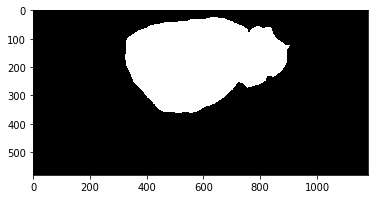

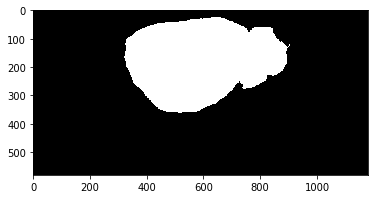

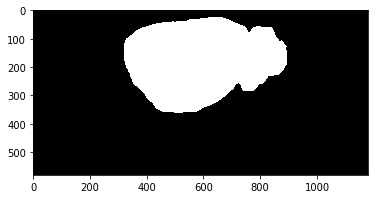

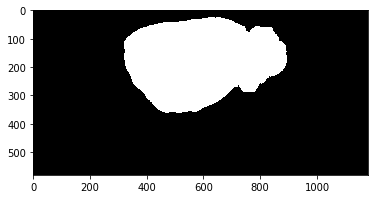

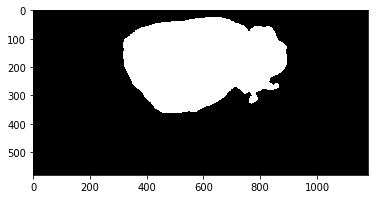

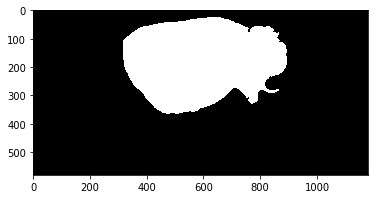

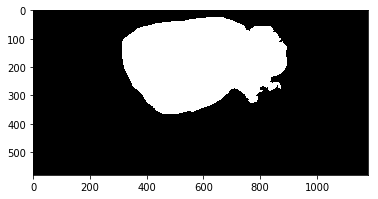

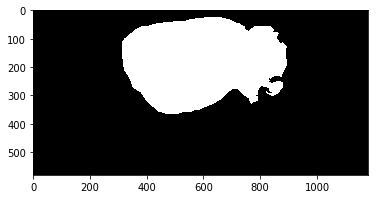

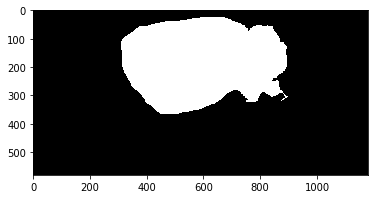

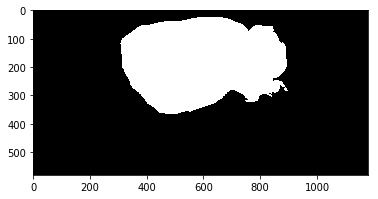

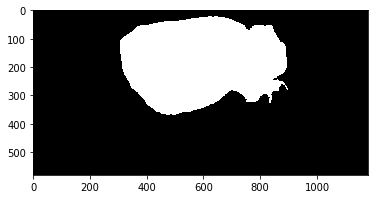

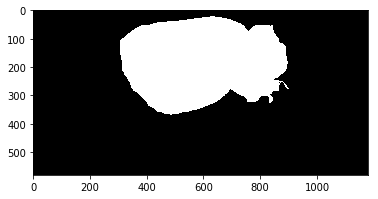

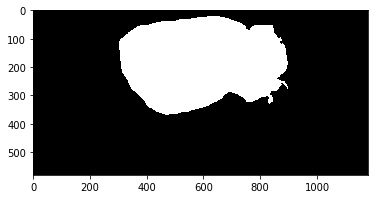

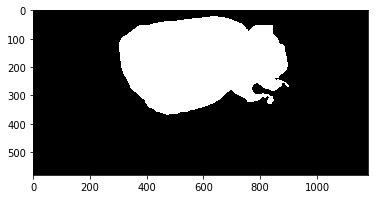

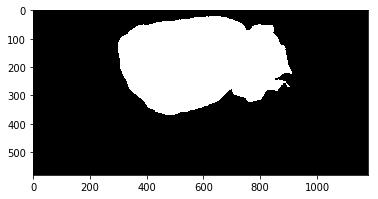

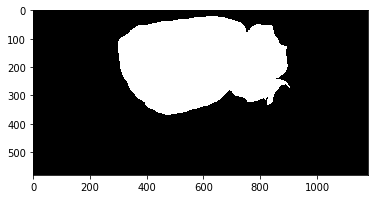

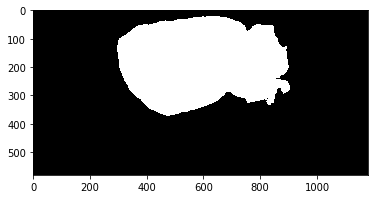

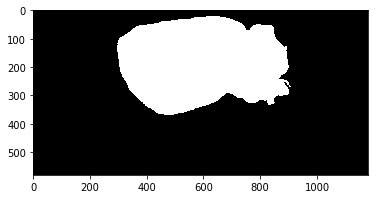

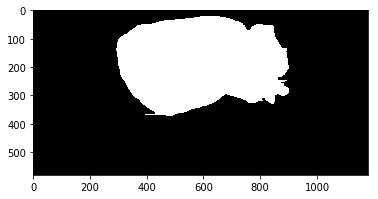

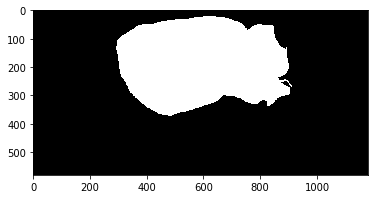

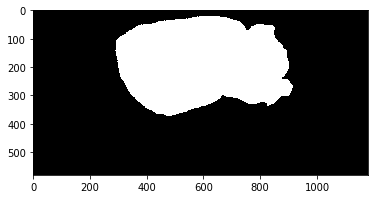

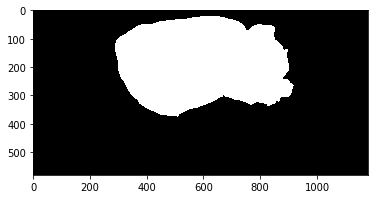

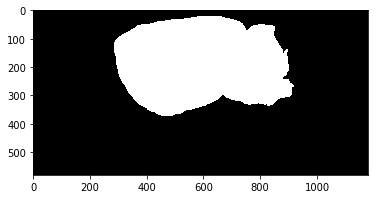

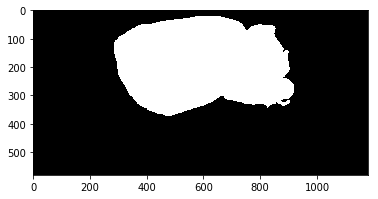

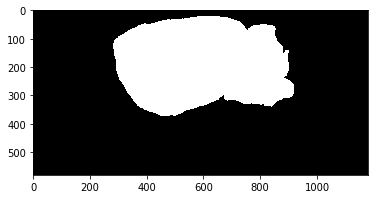

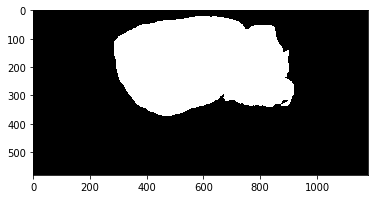

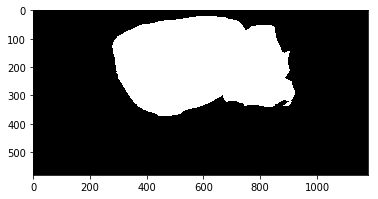

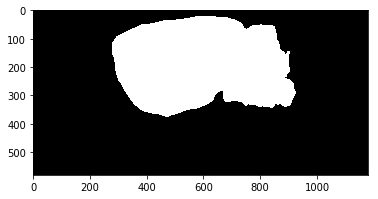

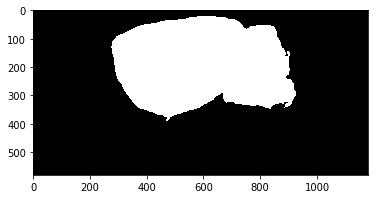

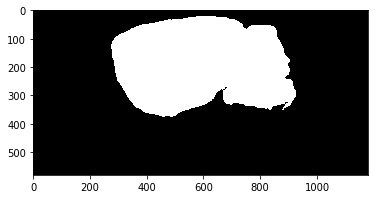

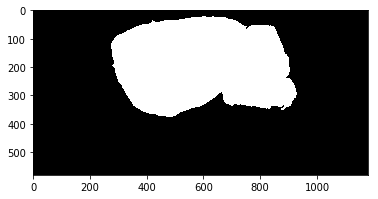

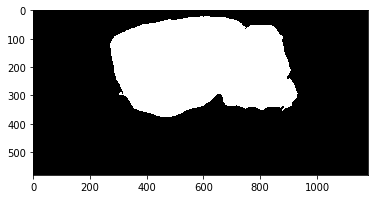

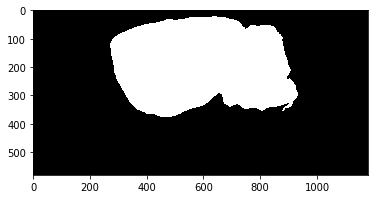

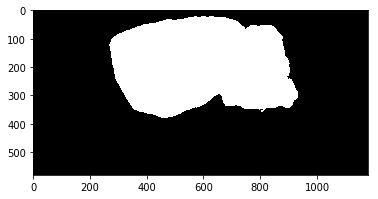

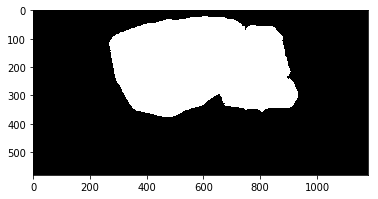

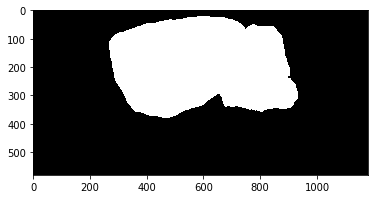

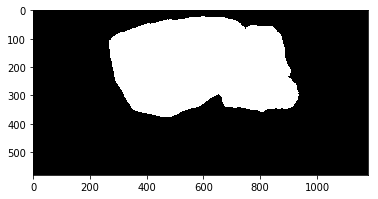

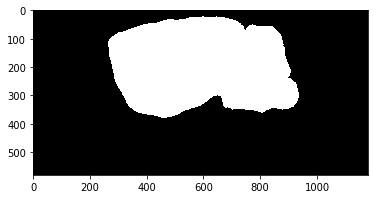

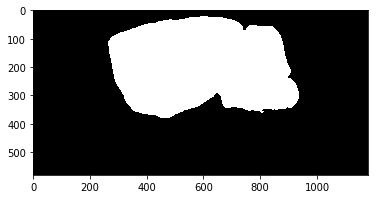

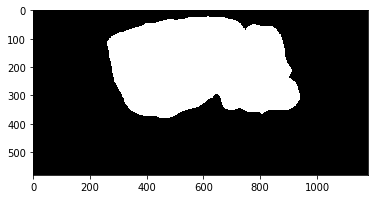

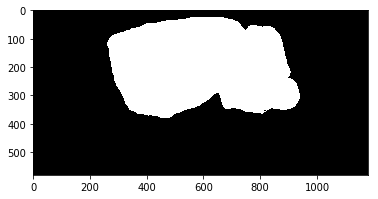

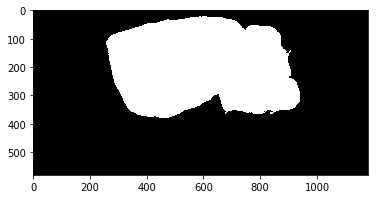

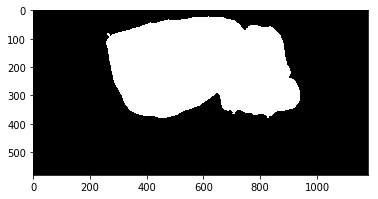

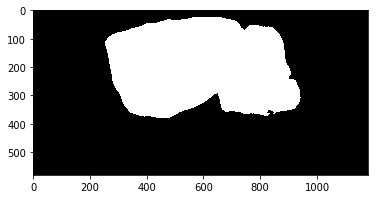

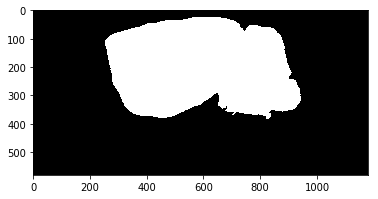

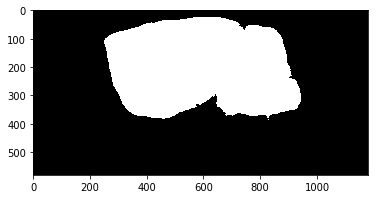

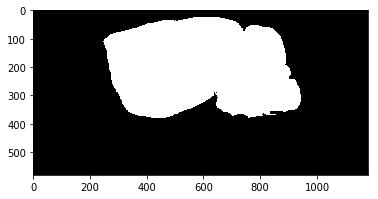

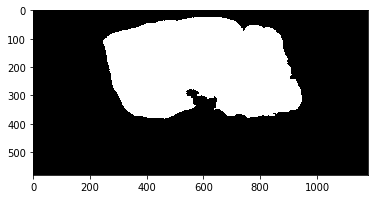

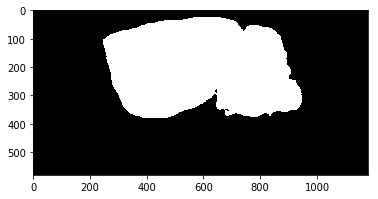

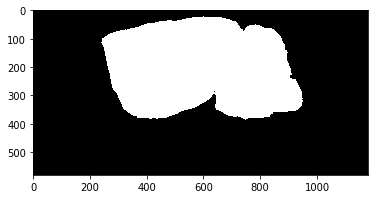

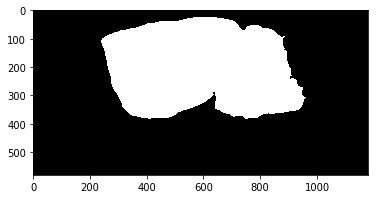

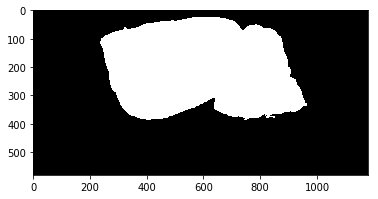

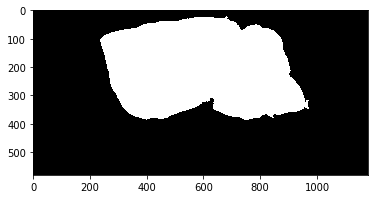

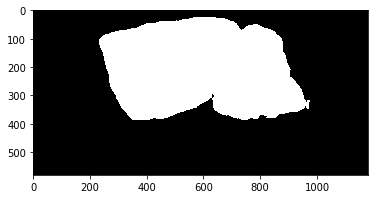

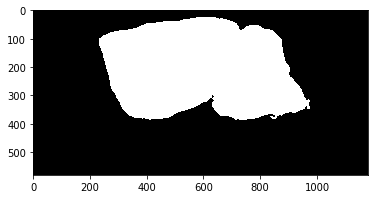

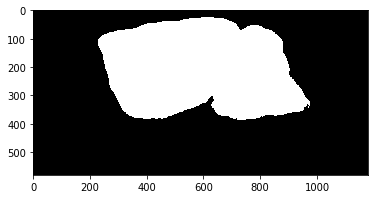

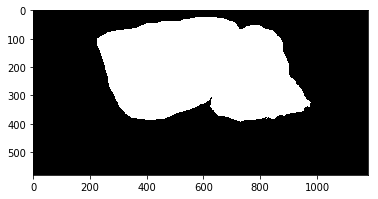

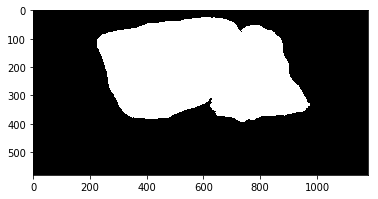

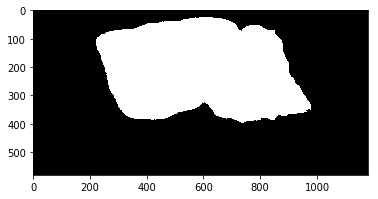

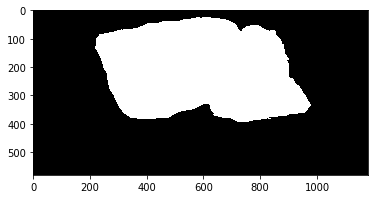

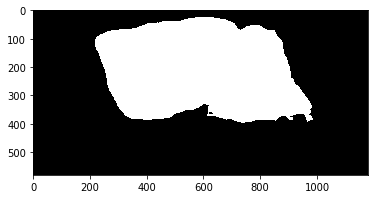

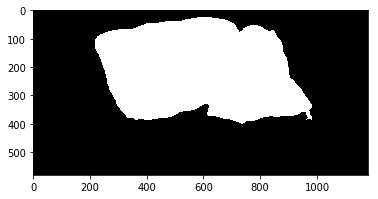

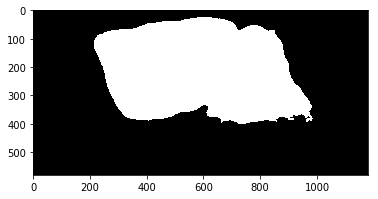

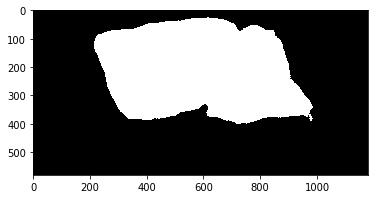

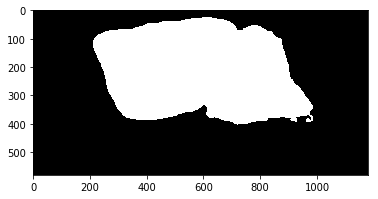

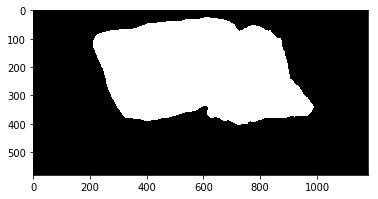

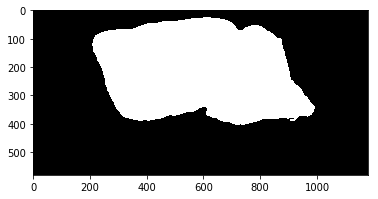

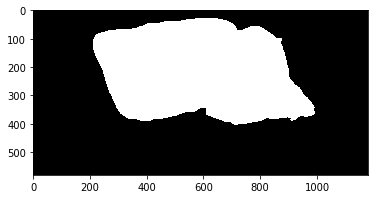

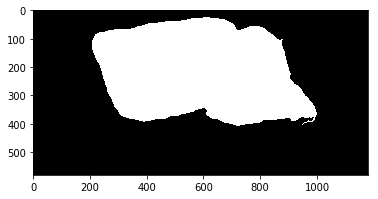

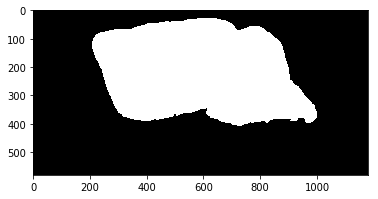

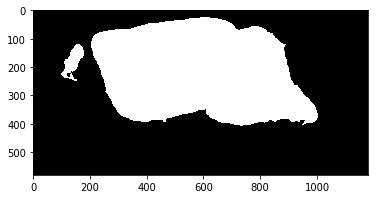

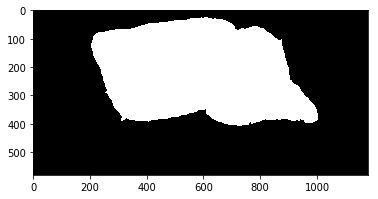

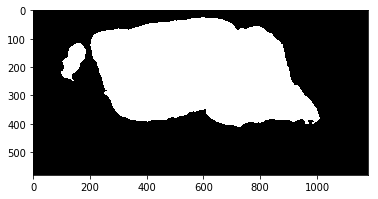

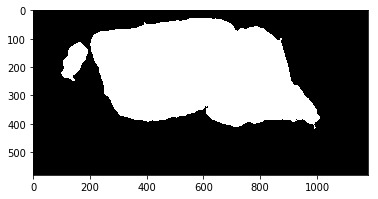

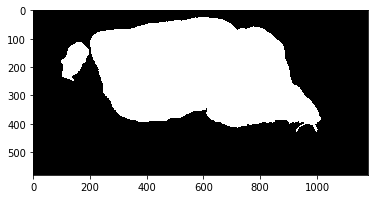

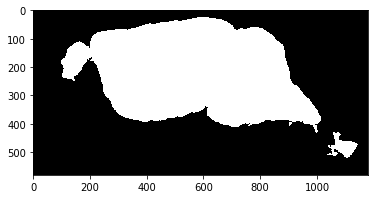

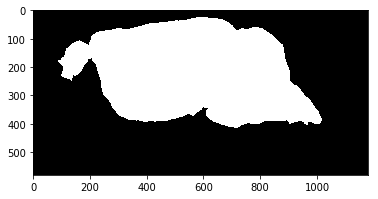

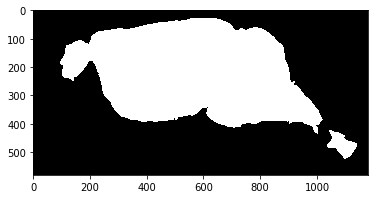

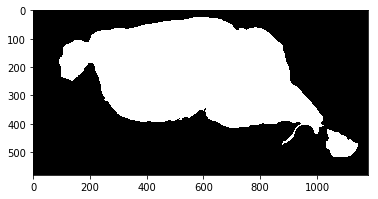

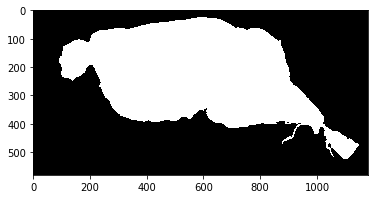

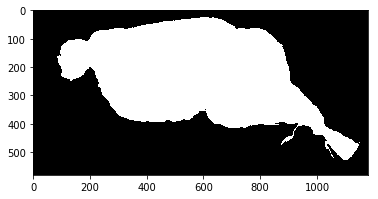

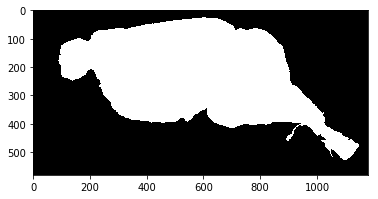

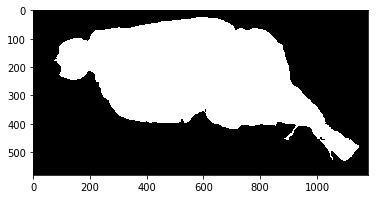

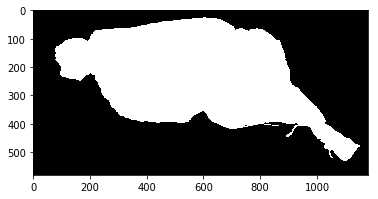

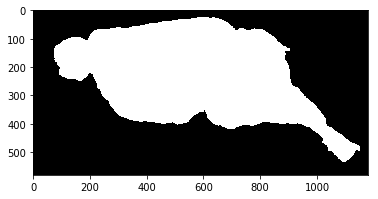

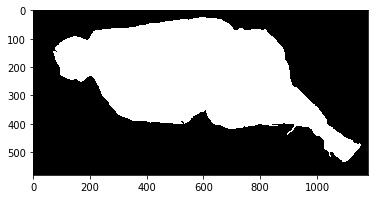

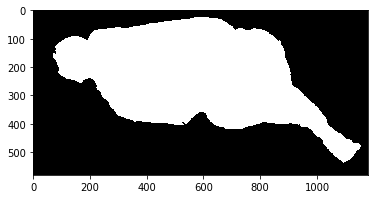

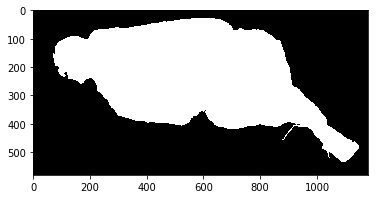

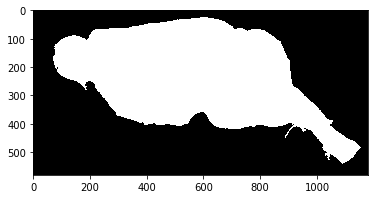

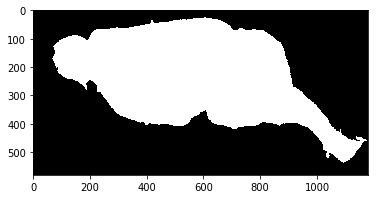

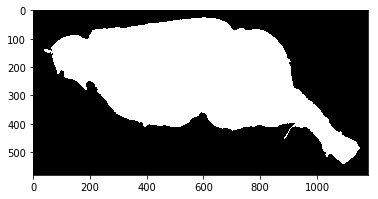

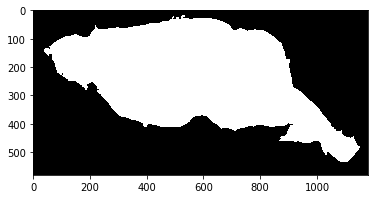

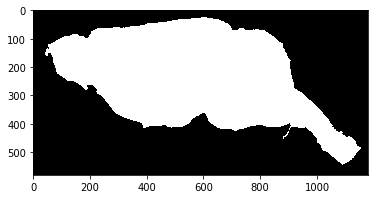

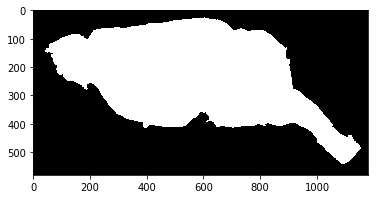

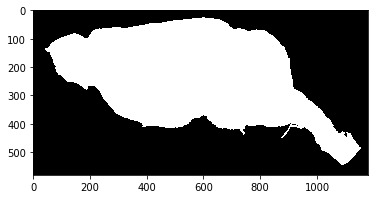

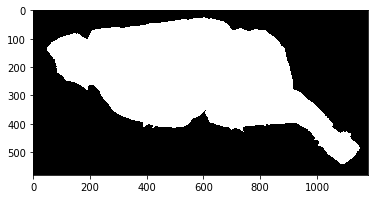

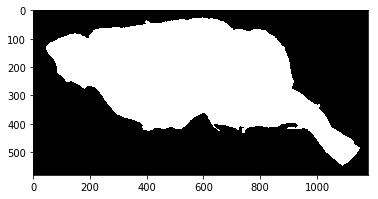

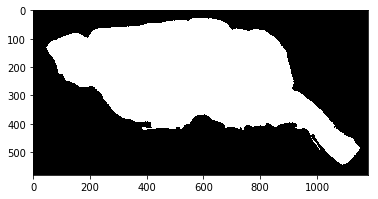

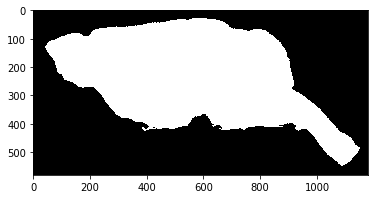

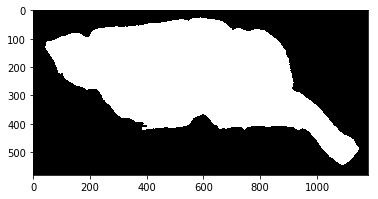

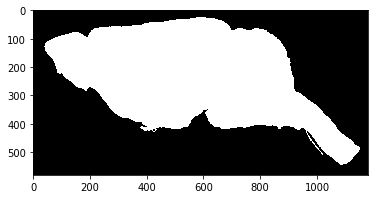

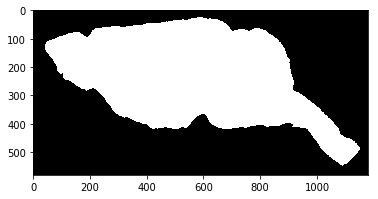

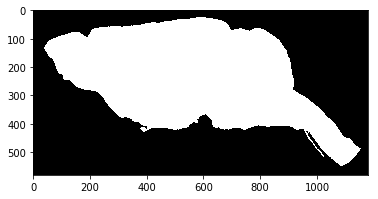

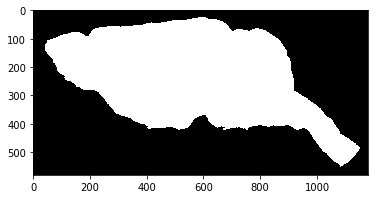

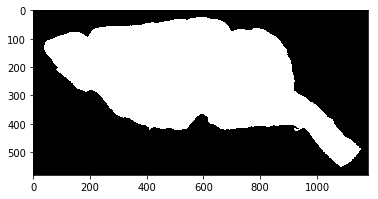

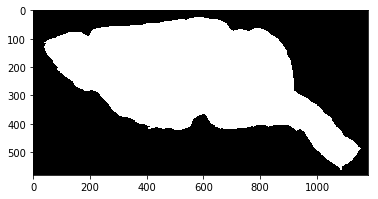

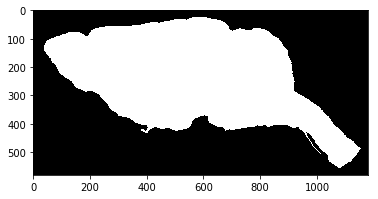

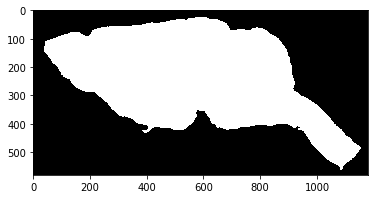

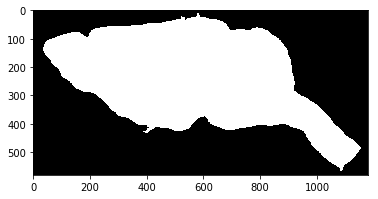

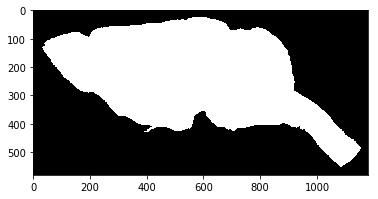

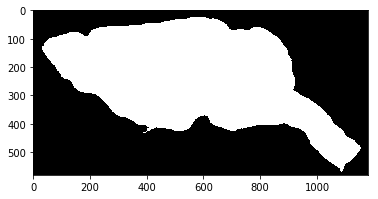

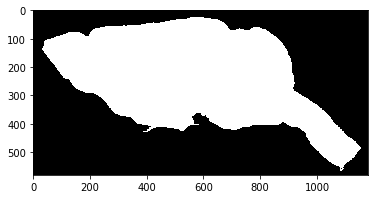

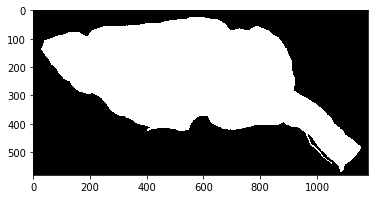

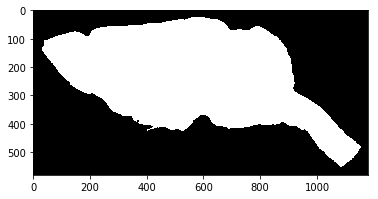

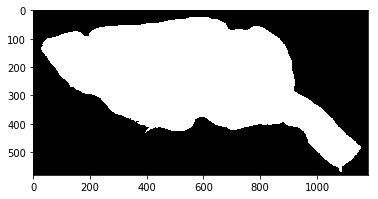

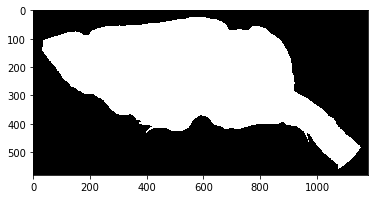

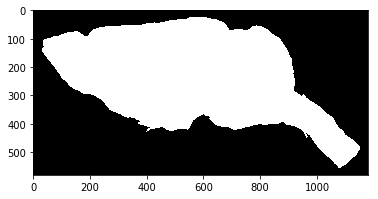

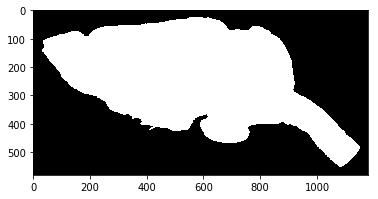

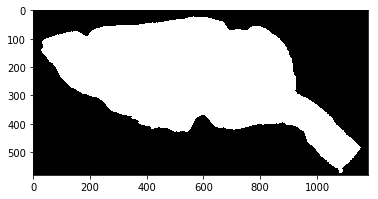

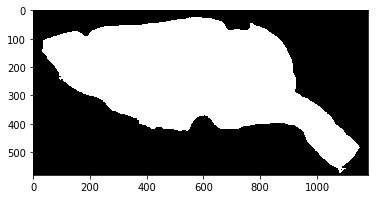

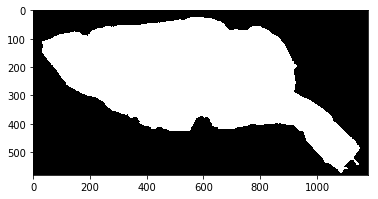

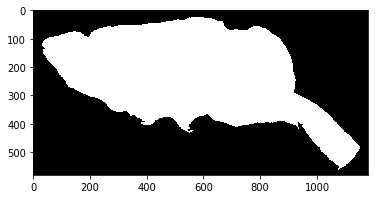

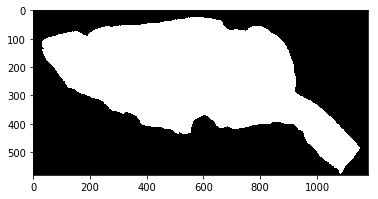

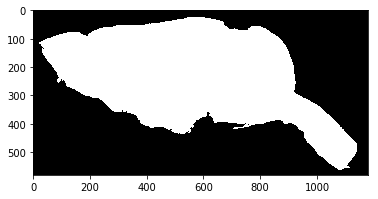

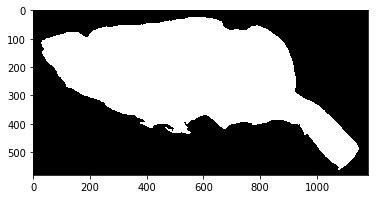

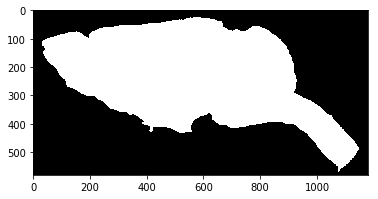

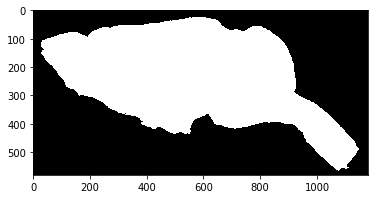

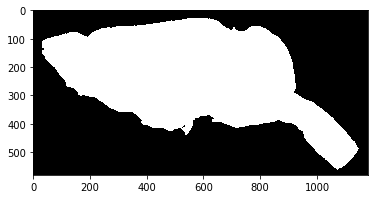

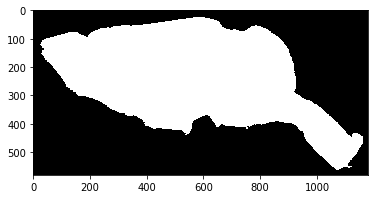

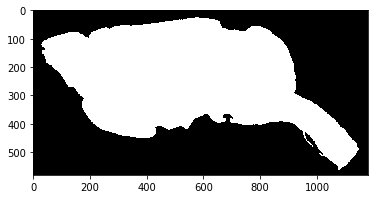

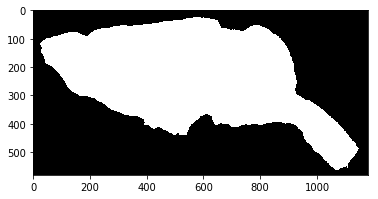

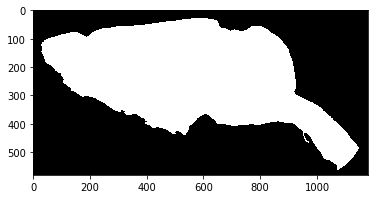

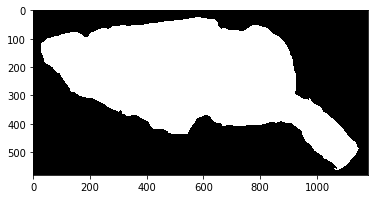

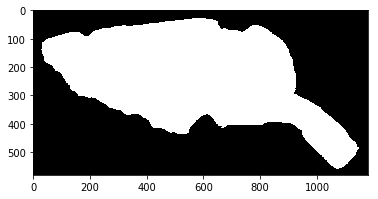

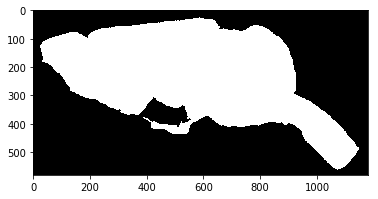

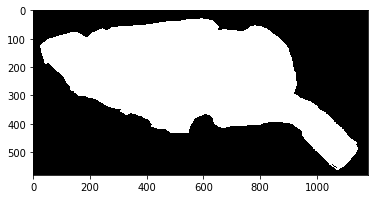

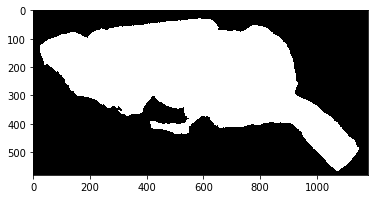

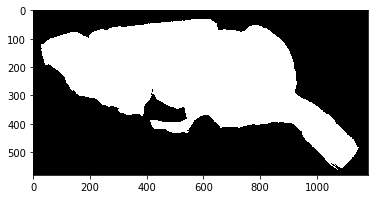

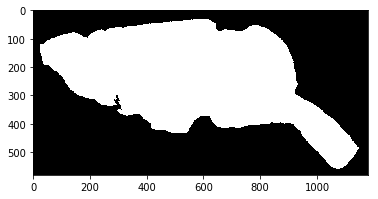

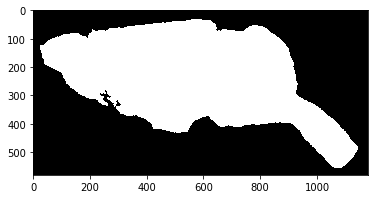

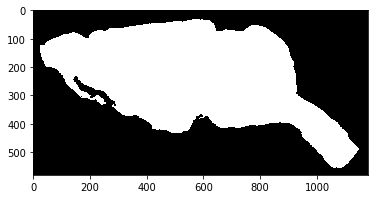

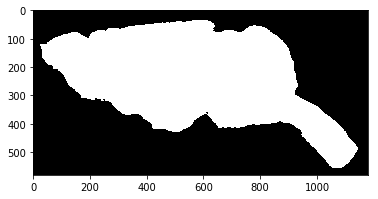

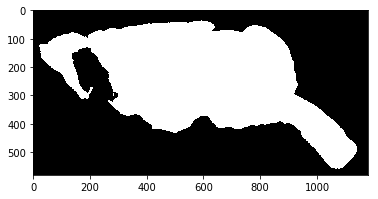

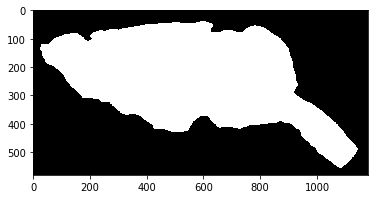

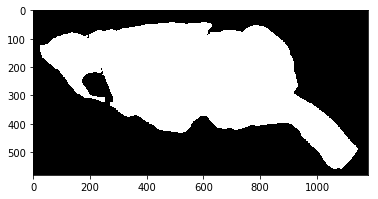

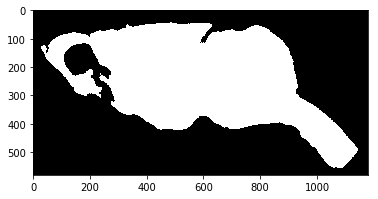

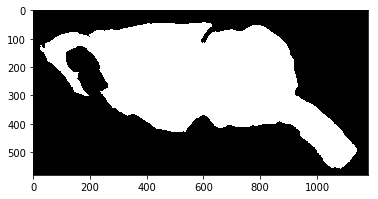

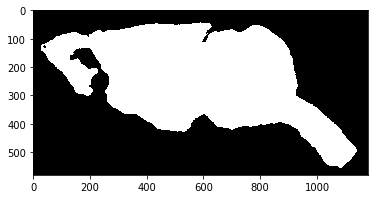

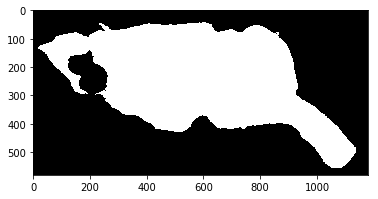

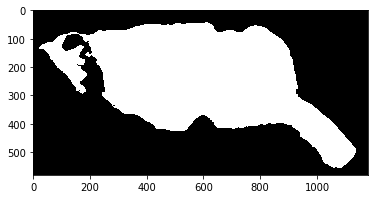

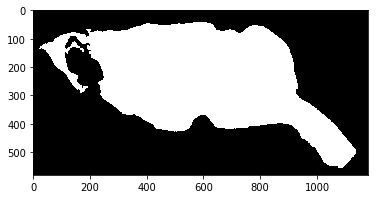

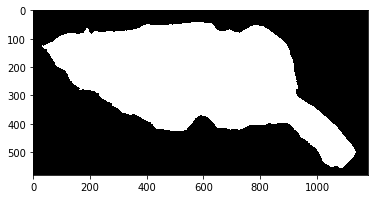

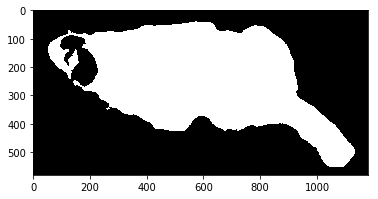

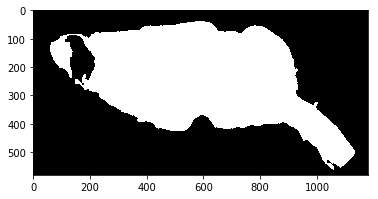

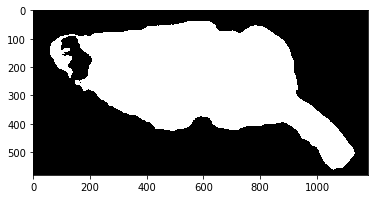

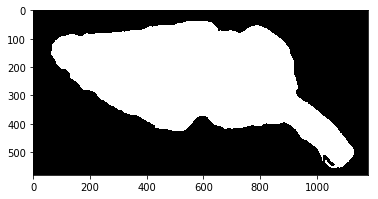

KeyboardInterrupt: 

In [49]:
for fn in metadata_cache['valid_filenames'][stack]:
    mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
    plt.figure();
    plt.imshow(mask_tb_alignedPadded[alignedWithMargin_ymin:alignedWithMargin_ymax+1, 
                                     alignedWithMargin_xmin:alignedWithMargin_xmax+1], cmap=plt.cm.gray)
    plt.show();

# Generate prep5 thumbnails from prep1 thumbnails
prep1_thumbnail_NtbNormalized -> prep5_thumbnail_NtbNormalized

In [ ]:
for stack in ['MD661']:

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id='alignedWithMargin',
                                                           return_dict=False, only_2d=True)
            
#     for section in metadata_cache['valid_sections_all'][stack]: # for CHATM2 and CHATM3
    for section in metadata_cache['valid_sections'][stack]: # for MD589 etc.
        
        for version in ['NtbNormalized']:
#         for version in [None, 'mask']:

            in_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=1, section=section, version=version, resol='thumbnail')

            out_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=5, section=section, version=version, resol='thumbnail')

            create_parent_dir_if_not_exists(out_fp)

            t = time.time()

            im_prep1 = imread(in_fp)
            im_prep5 = im_prep1[alignedWithMargin_ymin:alignedWithMargin_ymax+1, 
                                alignedWithMargin_xmin:alignedWithMargin_xmax+1]        
            save_data(im_prep5, out_fp)
            
            sys.stderr.write('Generate prep5: %.2f seconds.\n' % (time.time() - t))

# Generate prep5 from original (transform + crop)
- raw_NtbNormalizedAdaptiveInvertedGamma -> prep5_raw_NtbNormalizedAdaptiveInvertedGamma
- thumbnail_NtbNormalized -> prep5_thumbnail_NtbNormalized

In [38]:
version = 'NtbNormalized'
# new_prep_id = 5
new_prep_id = 'alignedWithMargin'

In [40]:
for stack in ['MD661']:

    anchor_fn = DataManager.load_anchor_filename(stack=stack)
    transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, 
                                                       use_inverse=False, anchor_fn=anchor_fn)

    if version == 'NtbNormalized': 
        pad_bg_color = 'black'
    elif version == 'NtbNormalizedAdaptiveInvertedGamma':
        pad_bg_color = 'white'

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id=new_prep_id,
                                                           return_dict=False, only_2d=True)

    x_tb = alignedWithMargin_xmin
    y_tb = alignedWithMargin_ymin
    w_tb = alignedWithMargin_xmax - alignedWithMargin_xmin + 1
    h_tb = alignedWithMargin_ymax - alignedWithMargin_ymin + 1
    
#     for resol in ['raw']:
    for resol in ['thumbnail']:

        input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol=resol)
        out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=new_prep_id, resol=resol, version=version)
        print 'out_dir:', out_dir
        script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

        # ! rm -rf {out_dir}

        # for version in ['CHAT']:
#         for version in ['NtbNormalizedAdaptiveInvertedGamma']:
#         for version in ['NtbNormalizedAdaptiveInvertedGamma']:

        t = time.time()

        if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
            run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %%(pad_bg_color)s' % \
                            {'script': script,
                            'stack': stack,
                             'x_tb': x_tb,
                            'y_tb': y_tb,
                            'w_tb': w_tb,
                            'h_tb': h_tb,
                             'resol': resol
                            },
                            kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                        'input_fp':\
                                          DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                            resol=resol, version=version, 
                                                                            fn=img_name),
                                        'output_fp':\
                                          DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                            prep_id=new_prep_id, version=version, 
                                                                            resol=resol),
                                        'pad_bg_color': 'black' if img_name.split('-')[1][0] == 'F' else 'white',
                                         }
                                        for img_name in metadata_cache['valid_filenames'][stack]
                                        ],
                            argument_type='single',
                           jobs_per_node=1,
                           local_only=True)
        else:
            run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %(pad_bg_color)s' % \
                            {'script': script,
                            'stack': stack,
                             'x_tb': x_tb,
                            'y_tb': y_tb,
                            'w_tb': w_tb,
                            'h_tb': h_tb,
                             'resol': resol,
                            'pad_bg_color': pad_bg_color
                            },
                            kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                        'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                                      resol=resol, version=version, 
                                                                                      fn=img_name),
                                        'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                       prep_id=new_prep_id, version=version, 
                                                                                       resol=resol),
                                         }
                                        for img_name in metadata_cache['valid_filenames'][stack]
                                        ],
                            argument_type='single',
                           jobs_per_node=8,
                           local_only=True)

        # wait_qsub_complete()

        print 'done in', time.time() - t, 'seconds'

out_dir: /data/CSHL_data_processed/MD661/MD661_prep5_thumbnail_NtbNormalized


rm -f ~/stderr_*; rm -f ~/stdout_*
return code: 0
Run locally.


done in 69.8076322079 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


# Generate prep5 thumbnails from prep5 raw
prep5_raw_NtbNormalizedAdaptiveInvertedGamma -> prep5_thumbnail_NtbNormalizedAdaptiveInvertedGamma

In [41]:
thumbnail_downscale_factor = 32

In [42]:
for stack in ['MD661']:
#     stack = 'CHATM2'

    for img_name in metadata_cache['valid_filenames'][stack]:
#     for img_name in ['CHATM2_slide66_2018_02_14-S1']:

        t = time.time()

        in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='raw', version='NtbNormalizedAdaptiveInvertedGamma', fn=img_name)
        out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='thumbnail', version='NtbNormalizedAdaptiveInvertedGamma', fn=img_name)
        create_parent_dir_if_not_exists(out_fp)

        img = imread(in_fp)
        imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

#         execute_command('convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp':in_fp, 'out_fp':out_fp})

        sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Rescale: 5.33 seconds.
Rescale: 5.33 seconds.
Rescale: 5.25 seconds.
Rescale: 5.42 seconds.
Rescale: 5.35 seconds.
Rescale: 5.36 seconds.
Rescale: 5.35 seconds.
Rescale: 5.46 seconds.
Rescale: 5.43 seconds.
Rescale: 5.66 seconds.
Rescale: 5.63 seconds.
Rescale: 5.62 seconds.
Rescale: 5.80 seconds.
Rescale: 5.96 seconds.
Rescale: 5.72 seconds.
Rescale: 5.86 seconds.
Rescale: 5.84 seconds.
Rescale: 5.82 seconds.
Rescale: 5.61 seconds.
Rescale: 5.69 seconds.
Rescale: 5.69 seconds.
Rescale: 5.71 seconds.
Rescale: 5.88 seconds.
Rescale: 5.74 seconds.
Rescale: 5.85 seconds.
Rescale: 5.85 seconds.
Rescale: 5.67 seconds.
Rescale: 5.79 seconds.
Rescale: 5.96 seconds.
Rescale: 5.89 seconds.
Rescale: 5.90 seconds.
Rescale: 6.11 seconds.
Rescale: 5.87 seconds.
Rescale: 6.15 seconds.
Rescale: 6.09 seconds.
Rescale: 6.12 seconds.
Rescale: 6.00 seconds.
Rescale: 6.09 seconds.
Rescale: 6.08 seconds.
Rescale: 6.14 seconds.
Rescale: 6.15 seconds.
Rescale: 6.16 seconds.
Rescale: 6.10 seconds.
Rescale: 6.

# Crop prep2 from prep5
- prep5_raw_NtbNormalizedAdaptiveInvertedGamma -> prep2_raw_NtbNormalizedAdaptiveInvertedGamma

In [7]:
from multiprocess import Pool

In [8]:
def f(stack, img_name, version, resol, x,y,w,h):

    input_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol=resol, version=version, fn=img_name)
    output_fp = DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=2, version=version, resol=resol)

    img = imread(input_fp)
    save_data(img[y:y+h, x:x+w], output_fp)

In [10]:
# for stack in ['CHATM2', 'CHATM3']:
for stack in ['MD661']:
    
    alignedBrainstemCrop_xmin_wrt_alignedWithMargin, \
    alignedBrainstemCrop_xmax_wrt_alignedWithMargin,\
    alignedBrainstemCrop_ymin_wrt_alignedWithMargin,\
    alignedBrainstemCrop_ymax_wrt_alignedWithMargin = \
    DataManager.load_cropbox_v2_relative(stack=stack, 
                                       prep_id='alignedBrainstemCrop', 
                                       wrt_prep_id='alignedWithMargin', 
                                       out_resolution='down32')
    
    x_tb = alignedBrainstemCrop_xmin_wrt_alignedWithMargin
    y_tb = alignedBrainstemCrop_ymin_wrt_alignedWithMargin
    w_tb = alignedBrainstemCrop_xmax_wrt_alignedWithMargin - alignedBrainstemCrop_xmin_wrt_alignedWithMargin + 1
    h_tb = alignedBrainstemCrop_ymax_wrt_alignedWithMargin - alignedBrainstemCrop_ymin_wrt_alignedWithMargin + 1
    
#     alignedBrainstemCrop_xmin, alignedBrainstemCrop_xmax, \
#     alignedBrainstemCrop_ymin, alignedBrainstemCrop_ymax = DataManager.load_cropbox_v2(stack=stack, prep_id='alignedBrainstemCrop', only_2d=True)

#     alignedWithMargin_xmin, alignedWithMargin_xmax,\
#     alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
#                                                             prep_id='alignedWithMargin',
#                                                            return_dict=False, only_2d=True)

#     alignedBrainstemCrop_xmin_wrt_alignedWithMargin = alignedBrainstemCrop_xmin - alignedWithMargin_xmin
#     alignedBrainstemCrop_xmax_wrt_alignedWithMargin = alignedBrainstemCrop_xmax - alignedWithMargin_xmin
#     alignedBrainstemCrop_ymin_wrt_alignedWithMargin = alignedBrainstemCrop_ymin - alignedWithMargin_ymin
#     alignedBrainstemCrop_ymax_wrt_alignedWithMargin = alignedBrainstemCrop_ymax - alignedWithMargin_ymin

#     print alignedBrainstemCrop_xmin_wrt_alignedWithMargin,\
#     alignedBrainstemCrop_xmax_wrt_alignedWithMargin,\
#     alignedBrainstemCrop_ymin_wrt_alignedWithMargin,\
#     alignedBrainstemCrop_ymax_wrt_alignedWithMargin

#     x_tb = alignedBrainstemCrop_xmin_wrt_alignedWithMargin
#     y_tb = alignedBrainstemCrop_ymin_wrt_alignedWithMargin
#     w_tb = alignedBrainstemCrop_xmax_wrt_alignedWithMargin - alignedBrainstemCrop_xmin_wrt_alignedWithMargin + 1
#     h_tb = alignedBrainstemCrop_ymax_wrt_alignedWithMargin - alignedBrainstemCrop_ymin_wrt_alignedWithMargin + 1

#     for version in ['NtbNormalizedAdaptiveInvertedGamma', 'CHAT']:
#     for version in ['CHAT']:
    for version in ['NtbNormalizedAdaptiveInvertedGamma']:
#     for version in ['mask']:
#         for resol in ['thumbnail']:
        for resol in ['raw']:
            
            if resol == 'raw':
                x = x_tb * 32
                y = y_tb * 32
                w = w_tb * 32
                h = h_tb * 32
            elif resol == 'thumbnail':
                x = x_tb
                y = y_tb
                w = w_tb
                h = h_tb
            else:
                raise

#             input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=5, version=version, resol='raw')
            out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=2, resol=resol, version=version)
            print 'out_dir:', out_dir
#             script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

    #         ! rm -rf {out_dir}
            create_if_not_exists(out_dir)

            t = time.time()

            pool = Pool(4)
            _ = pool.map(lambda img_name: f(stack=stack, img_name=img_name, version=version, resol=resol, 
                                            x=x, y=y, w=w, h=h), 
                         metadata_cache['valid_filenames'][stack])
            pool.close()
            pool.join()

#             for img_name in metadata_cache['valid_filenames'][stack]:
#                 f(stack=stack, img_name=img_name, version=version, resol=resol, 
#                                             x=x, y=y, w=w, h=h)

        #     run_distributed('convert \"%%(input_fp)s\" -crop %(w)dx%(h)d+%(x)d+%(y)d  \"%%(output_fp)s\"' % \
        #                     {'w':w_raw, 'h':h_raw, 'x':x_raw, 'y':y_raw},
        #                     kwargs_list=[{'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='raw', version=version, fn=img_name),
        #                                   'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=2, version=version, resol='raw')}
        #                                  for img_name in metadata_cache['valid_filenames'][stack]],
        # #                                  for img_name in ['CHATM3_slide35_2018_02_17-S1']],
        #                     argument_type='single',
        #                    jobs_per_node=1,
        #                    local_only=True)

            # wait_qsub_complete()

            print 'done in', time.time() - t, 'seconds' # 1500s

out_dir: /data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-dat

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_raw_NtbNo

return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_raw_NtbNo

return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_raw_NtbNo

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_raw_NtbNormalizedAdaptiv

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_raw_NtbNo

return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_raw_NtbNormalizedAdapti

return code: 0
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_raw_Ntb

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_raw_NtbNormalizedAdaptiveInvertedGamma

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3:/

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3:/

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_prep2_raw_

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0


done in 1463.65569592 seconds


# Compress prep2 to JPEG
prep2_raw_NtbNormalizedAdaptiveInvertedGamma -> prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg

In [17]:
for stack in ['MD661']:

    for section in metadata_cache['valid_sections'][stack]:
        
#         for version in ['NtbNormalizedAdaptiveInvertedGamma', 'CHAT']:
        for version in ['NtbNormalizedAdaptiveInvertedGamma']:

            in_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=2, section=section, version=version, resol='raw')

            out_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=2, section=section, version=version+'Jpeg', resol='raw')

            create_parent_dir_if_not_exists(out_fp)

            t = time.time()
            execute_command("convert \"%(in_fp)s\" \"%(out_fp)s\"" % {'in_fp': in_fp, 'out_fp': out_fp})
            sys.stderr.write('Convert to JPEG: %.2f seconds.\n' % (time.time() - t)) # 14s

            upload_to_s3(out_fp)

convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.43 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_raw_NtbN

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.58 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.64 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.63 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.54 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.19 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.75 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.73 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.88 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.00 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.98 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.60 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.80 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.95 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.29 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.97 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.57 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.11 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.23 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F102-2017.06.06-22.30.50_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.12 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F107-2017.06.07-00.44.42_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.98 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F112-2017.06.07-02.53.08_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.86 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F118-2017.06.07-11.26.45_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.90 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F122-2017.06.07-15.19.59_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.51 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F127-2017.06.07-17.34.51_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.65 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F130-2017.06.07-19.06.02_MD661_2

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.71 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F133-2017.06.07-20.35.00_MD661_3

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.57 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F137-2017.06.07-22.31.13_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.20 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_2